# Importing speech sentiments from Colab notebook

Previous steps of the data cleaning are not included in this notebook. Yet, I will shortly explain how the dataset come together to what it is now:
- The collection of the dataset goes back to ECB's page [ https://www.ecb.europa.eu/press/key/date/html/index.en.html ] that contains list of the speeches delivered by the Board members of the ECB for each day along with other details such as speaker and the topic or type of meeting.
- The dataset initially contained slightly more than 1200 observations, then speeches that has no translation in english, and given only in the speaker's language has been eliminated.
- The dataset has been split into small chunks in order for the FinBERT - the language model that particularly is used to extract sentiments of the text in the finance domain - to be able to process it. The limit for the FinBERT is 512 tensors per observation, and the speech has been split into chunks that matches the size with smaller margin of difference. Yet, the text is split into chunks with cross point being the closest full stop to the limit in order to maintain the coherence of the speech.
- Then the speech fragments along with their corresponding dates has been stored as another file comprising more than 45,000 observations , and the language model has been utilized on Cloud environment leveraging high performance GPU power to process it, and extract the sentiments.
- The language model classifies the parts of the speeches into three classes: negative, neutral and positive with probabilities ranging from 0 to 1.
- Utilizing the high-performance GPUs, I obtained the file in the following that has index, date column indicating the date the speech is delivered, content, the sentiment the model classified, it's probability, and info_channel is an indicator variable if the content comes from speeches, policy announcements or press releases. 

In [1]:
import pandas as pd
sentiments = pd.read_csv("src/Data/speech_all_finbert.csv").drop(columns=["Unnamed: 0"])
sentiments['info_channel'] = 'speech'
sentiments

date                                            content  \
0      1998-07-17  Mr. Duisenberg reports on the outcome of the s...   
1      1998-07-17  Economic growth has been driven increasingly b...   
2      1998-07-17  In principle, the economic performance I have ...   
3      1998-07-17  Third, further structural adjustments in fisca...   
4      1998-07-17  There is currently no sign of exchange rate te...   
...           ...                                                ...   
46014  2022-02-25  Since the exchange of confidential information...   
46015  2022-02-25  Last year, following discussions in the Counci...   
46016  2022-02-25  This type of measure has so far only been impl...   
46017  2022-02-25  The ECB incorporated in its opinions its exper...   
46018  2022-02-25  Also, considering the strict, risk-based natur...   

      sentiment  probability info_channel  
0      positive     0.854208       speech  
1      positive     0.947828       speech  
2       neutral     0.600082       speech  
3       neutral     0.824068       speech  
4       neutral     0.756298       speech  
...         ...          ...          ...  
46014  positive     0.664321       speech  
46015   neutral     0.762738       speech  
46016   neutral     0.897179       speech  
46017   neutral     0.868921       speech  
46018   neutral     0.909391       speech  

[46019 rows x 5 columns]

In [2]:
import pandas as pd

def generalize_sentiments(df):
    """
    Generalizes the sentiments of a dataframe by consolidating rows with the same date.
    It aggregates content by date, computes sentiment counts, and calculates max, min, and average 
    probabilities for each sentiment type (positive, negative, neutral).

    Parameters:
    - df (pandas.DataFrame): DataFrame containing 'date', 'content', 'sentiment', 
                             and respective sentiment probabilities columns.

    Returns:
    - pandas.DataFrame: DataFrame with consolidated content and aggregated sentiment metrics.
    """
    
    # Convert content to string to avoid TypeError and concatenate for rows with the same date
    consolidated_content = df.groupby('date')['content'].apply(lambda x: ' '.join(map(str, x))).reset_index()

    # Compute sentiment counts for each date
    sentiment_counts = df.groupby(['date', 'sentiment']).size().unstack().reset_index().fillna(0)
    sentiment_counts.columns = ['date'] + [f"{col.lower()}_counts" for col in sentiment_counts.columns if col != 'date']

    # Compute max, min, and average probabilities for each sentiment by date
    aggregations = {}
    for sentiment in ['positive', 'negative', 'neutral']:
        mask = df['sentiment'] == sentiment
        aggregated = df[mask].groupby('date').agg({
            'probability': ['max', 'min', 'mean']
        }).reset_index()
        
        # Flatten the multi-index column names
        aggregated.columns = ['date'] + [f"{sentiment}_{metric}" for metric in ['max', 'min', 'mean']]
        aggregations[sentiment] = aggregated

    # Merge the created dataframes to generate the final output
    result = consolidated_content
    result = pd.merge(result, sentiment_counts, on='date', how='inner')
    for sentiment in ['positive', 'negative', 'neutral']:
        result = pd.merge(result, aggregations[sentiment], on='date', how='inner')

    return result


In [3]:
gen_data = generalize_sentiments(sentiments)
gen_data['weighted_prob'] = (gen_data['negative_counts'] * gen_data['negative_mean'] * (-1) + gen_data['positive_counts'] * gen_data['positive_mean'] ) / (gen_data['negative_counts']+gen_data['positive_counts'])
gen_data['info_channel'] = 'speech'
gen_data.rename(columns={'date': 'Date'}, inplace=True)
gen_data

Date                                            content  \
0     1998-11-09  Mr. Duisenberg’s opening statement at the pres...   
1     1998-12-03  Mr Duisenberg reports on the current position ...   
2     1999-01-08  Mr Duisenberg’s opening statement at the press...   
3     1999-01-11  Mr Duisenberg’s opening statement at the press...   
4     1999-01-19  Mr Duisenberg’s opening statement at the Europ...   
...          ...                                                ...   
1247  2022-01-21  Christine Lagarde: Introductory statement at t...   
1248  2022-02-04  Christine Lagarde: Introductory statement at E...   
1249  2022-02-10  Christine Lagarde: Hearing of the Committee on...   
1250  2022-02-17  Christine Lagarde: Introductory statement - Eu...   
1251  2022-02-23  Frank Elderson: Prudential pathways to Paris C...   

      negative_counts  neutral_counts  positive_counts  positive_max  \
0                 6.0            13.0              2.0      0.899266   
1                 2.0            14.0              3.0      0.808924   
2                 2.0            18.0              2.0      0.923603   
3                10.0            23.0              2.0      0.817296   
4                 6.0            16.0              2.0      0.870406   
...               ...             ...              ...           ...   
1247              1.0             7.0             10.0      0.953582   
1248              4.0             1.0              4.0      0.954398   
1249              4.0             5.0              3.0      0.953364   
1250              3.0             8.0              5.0      0.946285   
1251              1.0            18.0              3.0      0.732960   

      positive_min  positive_mean  negative_max  negative_min  negative_mean  \
0         0.765561       0.832413      0.962060      0.523458       0.785708   
1         0.565346       0.677796      0.847879      0.645703       0.746791   
2         0.554621       0.739112      0.947072      0.880715       0.913893   
3         0.668759       0.743027      0.954375      0.496729       0.723577   
4         0.866672       0.868539      0.968294      0.739333       0.871450   
...            ...            ...           ...           ...            ...   
1247      0.613189       0.747925      0.466378      0.466378       0.466378   
1248      0.446699       0.824757      0.943139      0.491753       0.756767   
1249      0.543439       0.779126      0.943748      0.461614       0.703850   
1250      0.534803       0.763456      0.928384      0.727196       0.845817   
1251      0.559550       0.672941      0.478034      0.478034       0.478034   

      neutral_max  neutral_min  neutral_mean  weighted_prob info_channel  
0        0.948906     0.531514      0.870117      -0.381178       speech  
1        0.952718     0.680924      0.828251       0.107961       speech  
2        0.949159     0.535464      0.845749      -0.087391       speech  
3        0.950720     0.375282      0.818889      -0.479143       speech  
4        0.946656     0.559591      0.827322      -0.436452       speech  
...           ...          ...           ...            ...          ...  
1247     0.839482     0.542453      0.744504       0.637534       speech  
1248     0.539072     0.539072      0.539072       0.033995       speech  
1249     0.872223     0.506347      0.692795      -0.068289       speech  
1250     0.895302     0.626179      0.816141       0.159978       speech  
1251     0.921931     0.505331      0.808956       0.385197       speech  

[1252 rows x 16 columns]

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming gen_data is your dataframe
# Convert the date column to datetime type for better plotting
gen_data['Date'] = pd.to_datetime(gen_data['Date'])

# Calculate the moving average. Adjust the window size as needed.
window_size = 10  # Adjust this as per your preference
gen_data['moving_avg_sentiment'] = gen_data['weighted_prob'].rolling(window=window_size).mean()




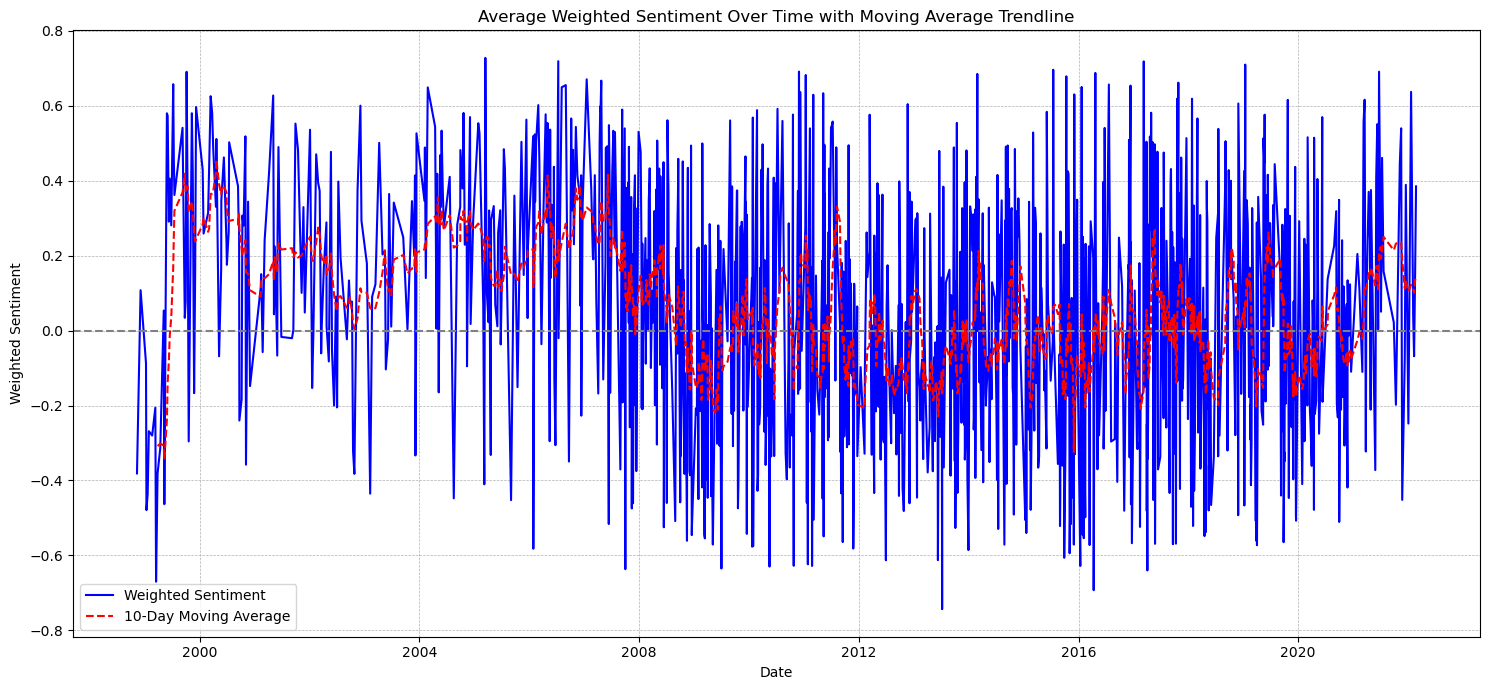

In [5]:
# Plotting
plt.figure(figsize=(15,7))
plt.plot(gen_data['Date'], gen_data['weighted_prob'], label='Weighted Sentiment', color='blue')
plt.plot(gen_data['Date'], gen_data['moving_avg_sentiment'], "r--", label=f'{window_size}-Day Moving Average')
plt.axhline(y=0, color='grey', linestyle='--')  # A line at y=0 for reference

plt.title('Average Weighted Sentiment Over Time with Moving Average Trendline')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Bring other time series variables

In [6]:
import yfinance as yf
import pandas as pd

# Define the path to your data file
data_path = "src/Data/stoxx.txt"

# Read the data file into a DataFrame
vstoxx_df = pd.read_csv(data_path, delimiter=";", parse_dates=["Date"], dayfirst=True)

# Change the date format to DD-MM-YYYY
vstoxx_df["Date_merge"] = vstoxx_df["Date"].dt.strftime("%d-%m-%Y")

# generate day of the week column
vstoxx_df['day_of_week'] = pd.to_datetime(vstoxx_df['Date']).dt.day_name()

# generate month column
vstoxx_df['month'] = pd.to_datetime(vstoxx_df['Date']).dt.month_name()

# Create lag variables
vstoxx_df['vstoxx_lag_1'] = vstoxx_df['Indexvalue'].shift(1)
vstoxx_df['vstoxx_lag_2'] = vstoxx_df['Indexvalue'].shift(2)
vstoxx_df['vstoxx_lag_3'] = vstoxx_df['Indexvalue'].shift(3)
vstoxx_df['vstoxx_lag_4'] = vstoxx_df['Indexvalue'].shift(4)
vstoxx_df['vstoxx_lag_5'] = vstoxx_df['Indexvalue'].shift(5)

# Create moving averages
vstoxx_df['vstoxx_ma_7'] = vstoxx_df['Indexvalue'].rolling(window=7).mean()
vstoxx_df['vstoxx_ma_30'] = vstoxx_df['Indexvalue'].rolling(window=30).mean()

# Create delta variables
vstoxx_df['vstoxx_delta_1'] = vstoxx_df['Indexvalue'].diff(1)
vstoxx_df['vstoxx_delta_2'] = vstoxx_df['Indexvalue'].diff(2)
vstoxx_df['vstoxx_delta_3'] = vstoxx_df['Indexvalue'].diff(3)



# Bond price data

In [7]:
bond_data = pd.read_csv("src/Data/10_year_maturity.csv")
# change variable names to Date and 10_y_bond_yield

bond_data.columns = ['Date', 'Date_2', '10_y_bond_yield']

# delta 1
bond_data['10_y_bond_delta_1'] = bond_data['10_y_bond_yield'].diff(1)

# moving average of last 10 days
bond_data['10_y_bond_ma_10'] = bond_data['10_y_bond_yield'].rolling(window=10).mean()

# drop the second date column
bond_data = bond_data.drop(columns=['Date_2'])
bond_data['Date'] = pd.to_datetime(bond_data['Date'])
bond_data

Date  10_y_bond_yield  10_y_bond_delta_1  10_y_bond_ma_10
0    2004-09-06         4.209220                NaN              NaN
1    2004-09-07         4.209626           0.000406              NaN
2    2004-09-08         4.228419           0.018793              NaN
3    2004-09-09         4.161872          -0.066547              NaN
4    2004-09-10         4.120981          -0.040891              NaN
...         ...              ...                ...              ...
4867 2023-09-15         2.734948           0.050649         2.690594
4868 2023-09-18         2.788173           0.053225         2.705558
4869 2023-09-19         2.807675           0.019502         2.719518
4870 2023-09-20         2.765770          -0.041905         2.728258
4871 2023-09-21         2.822552           0.056782         2.739225

[4872 rows x 4 columns]

In [8]:
# import the yield curve data
yield_curve = pd.read_csv("src/Data/euro_yield_curve.csv")

# Select only 'date' and 's1' columns
yield_curve = yield_curve[['date', 's1']]

# Rename the 's1' column to 's1_yield'
yield_curve.rename(columns={'s1': 'euro_yield'}, inplace=True)
yield_curve.rename(columns={'date': 'Date'}, inplace=True)

# delta 1
yield_curve['euro_yield_delta_1'] = yield_curve['euro_yield'].diff(1)

# lag 1
yield_curve['euro_yield_lag_1'] = yield_curve['euro_yield'].shift(1)

# moving average of last 10 days
yield_curve['euro_yield_ma_10'] = yield_curve['euro_yield'].rolling(window=10).mean()

yield_curve 

Date  euro_yield  euro_yield_delta_1  euro_yield_lag_1  \
0     2004-09-06    3.298175                 NaN               NaN   
1     2004-09-07    3.338711            0.040536          3.298175   
2     2004-09-08    3.375993            0.037282          3.338711   
3     2004-09-09    3.284360           -0.091633          3.375993   
4     2004-09-10    3.208441           -0.075919          3.284360   
...          ...         ...                 ...               ...   
4843  2023-08-14    2.370727            0.040967          2.329760   
4844  2023-08-15    2.448853            0.078126          2.370727   
4845  2023-08-16    2.428063           -0.020790          2.448853   
4846  2023-08-17    2.466451            0.038388          2.428063   
4847  2023-08-18    2.326963           -0.139488          2.466451   

      euro_yield_ma_10  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
4843          2.297317  
4844          2.308941  
4845          2.325633  
4846          2.346134  
4847          2.340720  

[4848 rows x 5 columns]

In [9]:
ref_rate = pd.read_csv("src/Data/main_ref_rate.csv")

# keep only date and s10
ref_rate = ref_rate[['date', 's12']]
# input the last value to the NaNs
ref_rate['s12'] = ref_rate['s12'].fillna(method='ffill')
# rename the columns
ref_rate.rename(columns={'s12': 'main_ref_rate'}, inplace=True)
# remove the NaNs
ref_rate = ref_rate.dropna()
# transform 1998-12-31 24:00:00 to 1999-01-01 00:00:00 format in date column
ref_rate['Date'] = ref_rate['date'].str.replace(' 24:00:00', ' 00:00:00')
# convert date to datetime format

ref_rate['Date'] = pd.to_datetime(ref_rate['Date'])


ref_rate.drop(columns=['date'], inplace=True)

ref_rate


main_ref_rate       Date
0              3.00 1998-12-31
1              3.00 1999-01-01
2              3.00 1999-01-02
3              3.00 1999-01-03
4              3.00 1999-01-04
...             ...        ...
9005           4.25 2023-08-27
9006           4.25 2023-08-28
9007           4.25 2023-08-29
9008           4.25 2023-08-30
9009           4.25 2023-08-31

[9010 rows x 2 columns]

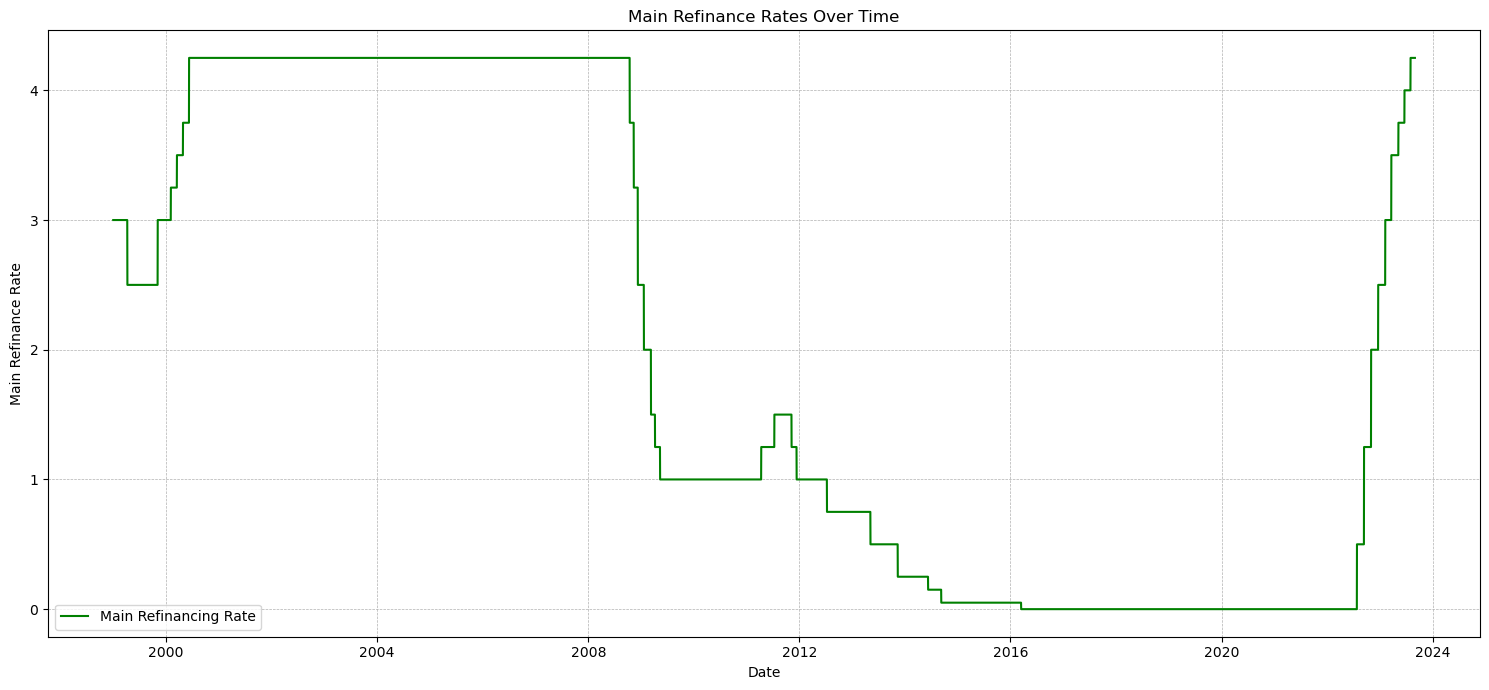

In [10]:
# plot s3, s8 and s10 rates over time
plt.figure(figsize=(15,7))
plt.plot(ref_rate['Date'], ref_rate['main_ref_rate'], label='Main Refinancing Rate', color='green')
plt.title('Main Refinance Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Main Refinance Rate')
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


# Labor and unemployment data

In [11]:
# import and transform the data for labor productivity
labor = pd.read_csv("src/Data/Labor_productivity.csv")

# import and transform the data for unemployment
unemployment = pd.read_csv("src/Data/Unemployment.csv")

In [12]:
unemployment

date  conf       status1    s1
0    2000-01-30 24:00:00   NaN  Normal value  9.44
1    2000-02-28 24:00:00   NaN  Normal value  9.35
2    2000-03-30 24:00:00   NaN  Normal value  9.26
3    2000-04-29 24:00:00   NaN  Normal value  9.18
4    2000-05-30 24:00:00   NaN  Normal value  9.12
..                   ...   ...           ...   ...
277  2023-02-27 24:00:00   NaN  Normal value  6.59
278  2023-03-30 24:00:00   NaN  Normal value  6.52
279  2023-04-29 24:00:00   NaN  Normal value  6.45
280  2023-05-30 24:00:00   NaN  Normal value  6.40
281  2023-06-29 24:00:00   NaN  Normal value  6.36

[282 rows x 4 columns]

In [13]:
# Adjust the time and increment the date
def adjust_time(date_string):
    if '24:00:00' in date_string:
        date_string = date_string.replace('24:00:00', '00:00:00')
        date_object = pd.to_datetime(date_string) + pd.Timedelta(days=1)
        return date_object.date()
    else:
        return pd.to_datetime(date_string).date()

labor['Date'] = labor['date'].apply(adjust_time)
unemployment['Date'] = unemployment['date'].apply(adjust_time)

In [14]:
import pandas as pd

# Sample data loading (you might have your own way of reading these dataframes)
# labor = pd.read_csv("path_to_labor.csv")
# unemployment = pd.read_csv("path_to_unemployment.csv")

# Merge the dataframes using an outer join
labor_unemployment = pd.merge(labor[['Date', 's1']], 
                              unemployment[['date', 's1']], 
                              left_on='Date', 
                              right_on='date', 
                              how='outer', 
                              suffixes=('_labor', '_unemployment'))

# Drop redundant date column
labor_unemployment.drop(columns=['Date'], inplace=True)

# Rename columns for clarity
labor_unemployment.rename(columns={
    'date': 'Date',
    's1_labor': 'labor_prod_s1', 
    's1_unemployment': 'unemployment_s1'
}, inplace=True)

# Handle missing values by forward filling
labor_unemployment['labor_prod_s1'] = labor_unemployment['labor_prod_s1'].fillna(method='ffill')
labor_unemployment['unemployment_s1'] = labor_unemployment['unemployment_s1'].fillna(method='ffill')

# Display the merged dataframe
labor_unemployment

labor_prod_s1                 Date  unemployment_s1
0             0.22                  NaN              NaN
1             0.38                  NaN              NaN
2             1.01                  NaN              NaN
3             2.01                  NaN              NaN
4             1.96                  NaN              NaN
..             ...                  ...              ...
375          -0.77  2023-02-27 24:00:00             6.59
376          -0.77  2023-03-30 24:00:00             6.52
377          -0.77  2023-04-29 24:00:00             6.45
378          -0.77  2023-05-30 24:00:00             6.40
379          -0.77  2023-06-29 24:00:00             6.36

[380 rows x 3 columns]

# Dax data

In [15]:
dax_selected = pd.read_csv("src/Data/^GDAXI.csv")

# keep only date, close and volume
dax_selected = dax_selected[['Date', 'Close', 'Volume']]
dax_selected.rename(columns={'Close': 'Close_dax', 'Volume':'Volume_dax'}, inplace=True)

# dax delta 1
dax_selected['dax_delta_1'] = dax_selected['Close_dax'].diff(1)

# dax lag 1
dax_selected['dax_lag_1'] = dax_selected['Close_dax'].shift(1)

# dax moving average of last 10 days
dax_selected['dax_ma_10'] = dax_selected['Close_dax'].rolling(window=10).mean()

dax_selected

Date     Close_dax  Volume_dax  dax_delta_1     dax_lag_1  \
0     2000-01-03   6750.759766  43072500.0          NaN           NaN   
1     2000-01-04   6586.950195  46678400.0  -163.809571   6750.759766   
2     2000-01-05   6502.069824  52682800.0   -84.880371   6586.950195   
3     2000-01-06   6474.919922  41180600.0   -27.149902   6502.069824   
4     2000-01-07   6780.959961  56058900.0   306.040039   6474.919922   
...          ...           ...         ...          ...           ...   
6064  2023-09-18  15727.120117  58899600.0  -166.410156  15893.530273   
6065  2023-09-19  15664.480469  53581800.0   -62.639648  15727.120117   
6066  2023-09-20  15781.589844  54733100.0   117.109375  15664.480469   
6067  2023-09-21  15571.860352  65995100.0  -209.729492  15781.589844   
6068  2023-09-22  15557.290039  70200200.0   -14.570313  15571.860352   

         dax_ma_10  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
6064  15756.853125  
6065  15746.130176  
6066  15750.152148  
6067  15735.472168  
6068  15717.171191  

[6069 rows x 6 columns]

In [16]:
# import volatility data
volatility = pd.read_csv("src/Data/^EVZ volatility.csv")
# keep only date and close
volatility = volatility[['Date', 'Close']]

# rename close to close_volatility
volatility.rename(columns={'Close': 'Close_volatility'}, inplace=True)

# volatility delta 1
volatility['volatility_delta_1'] = volatility['Close_volatility'].diff(1)

# volatility lag 1
volatility['volatility_lag_1'] = volatility['Close_volatility'].shift(1)

# volatility moving average of last 10 days
volatility['volatility_ma_10'] = volatility['Close_volatility'].rolling(window=10).mean()

volatility

Date  Close_volatility  volatility_delta_1  volatility_lag_1  \
0     2008-09-25         14.420000                 NaN               NaN   
1     2008-09-26         14.990000            0.570000         14.420000   
2     2008-09-29         15.320000            0.330000         14.990000   
3     2008-09-30         18.719999            3.399999         15.320000   
4     2008-10-01         17.280001           -1.439998         18.719999   
...          ...               ...                 ...               ...   
3769  2023-09-18          6.750000           -0.170000          6.920000   
3770  2023-09-19          6.920000            0.170000          6.750000   
3771  2023-09-20          6.800000           -0.120000          6.920000   
3772  2023-09-21          7.250000            0.450000          6.800000   
3773  2023-09-22          6.810000           -0.440000          7.250000   

      volatility_ma_10  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
3769             7.213  
3770             7.147  
3771             7.067  
3772             7.032  
3773             6.983  

[3774 rows x 5 columns]

# Merge all of them into one


In [17]:
dfs = [gen_data, vstoxx_df, bond_data, yield_curve, ref_rate, labor_unemployment, dax_selected, volatility]
# Ensure 'Date' columns of all dataframes are corrected and of type datetime64[ns]
for df in dfs:
    # Convert 'Date' column to string for string operations
    df['Date'] = df['Date'].astype(str)
    
    # Replace '24:00:00' with '00:00:00' and add a day
    mask = df['Date'].str.contains('24:00:00', na=False)
    df.loc[mask, 'Date'] = pd.to_datetime(df['Date'].str.replace('24:00:00', '00:00:00')) + pd.Timedelta(days=1)
    
    # Convert to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

# Initialize 'merged_df' with the first dataframe
merged_df = dfs[0].copy()

# Iteratively merge the other dataframes
for i, df in enumerate(dfs[1:], 2):  # Start enumeration at 2 for suffix purposes
    # Find overlapping columns (other than 'Date')
    overlapping_columns = df.columns[df.columns.isin(merged_df.columns) & (df.columns != 'Date')]
    
    # For overlapping columns in the next dataframe, add suffixes
    df = df.rename(columns={col: f"{col}_df{i}" for col in overlapping_columns})
    
    # Merge
    merged_df = merged_df.merge(df, on='Date', how='outer')

# Display the merged dataframe
merged_df
# print(merged_df.shape)


Date                                            content  \
0    1998-11-09  Mr. Duisenberg’s opening statement at the pres...   
1    1998-12-03  Mr Duisenberg reports on the current position ...   
2    1999-01-08  Mr Duisenberg’s opening statement at the press...   
3    1999-01-11  Mr Duisenberg’s opening statement at the press...   
4    1999-01-19  Mr Duisenberg’s opening statement at the Europ...   
...         ...                                                ...   
9121        NaT                                                NaN   
9122        NaT                                                NaN   
9123        NaT                                                NaN   
9124        NaT                                                NaN   
9125 2023-09-22                                                NaN   

      negative_counts  neutral_counts  positive_counts  positive_max  \
0                 6.0            13.0              2.0      0.899266   
1                 2.0            14.0              3.0      0.808924   
2                 2.0            18.0              2.0      0.923603   
3                10.0            23.0              2.0      0.817296   
4                 6.0            16.0              2.0      0.870406   
...               ...             ...              ...           ...   
9121              NaN             NaN              NaN           NaN   
9122              NaN             NaN              NaN           NaN   
9123              NaN             NaN              NaN           NaN   
9124              NaN             NaN              NaN           NaN   
9125              NaN             NaN              NaN           NaN   

      positive_min  positive_mean  negative_max  negative_min  ...  \
0         0.765561       0.832413      0.962060      0.523458  ...   
1         0.565346       0.677796      0.847879      0.645703  ...   
2         0.554621       0.739112      0.947072      0.880715  ...   
3         0.668759       0.743027      0.954375      0.496729  ...   
4         0.866672       0.868539      0.968294      0.739333  ...   
...            ...            ...           ...           ...  ...   
9121           NaN            NaN           NaN           NaN  ...   
9122           NaN            NaN           NaN           NaN  ...   
9123           NaN            NaN           NaN           NaN  ...   
9124           NaN            NaN           NaN           NaN  ...   
9125           NaN            NaN           NaN           NaN  ...   

      unemployment_s1     Close_dax  Volume_dax  dax_delta_1     dax_lag_1  \
0                 NaN           NaN         NaN          NaN           NaN   
1                 NaN           NaN         NaN          NaN           NaN   
2                 NaN           NaN         NaN          NaN           NaN   
3                 NaN           NaN         NaN          NaN           NaN   
4                 NaN           NaN         NaN          NaN           NaN   
...               ...           ...         ...          ...           ...   
9121              NaN           NaN         NaN          NaN           NaN   
9122              NaN           NaN         NaN          NaN           NaN   
9123              NaN           NaN         NaN          NaN           NaN   
9124              NaN           NaN         NaN          NaN           NaN   
9125              NaN  15557.290039  70200200.0   -14.570313  15571.860352   

         dax_ma_10  Close_volatility volatility_delta_1  volatility_lag_1  \
0              NaN               NaN                NaN               NaN   
1              NaN               NaN                NaN               NaN   
2              NaN               NaN                NaN               NaN   
3              NaN               NaN                NaN               NaN   
4              NaN               NaN                NaN               NaN   
...            ...               ...                ...          

In [18]:
merged_df.columns.tolist()


['Date',
 'content',
 'negative_counts',
 'neutral_counts',
 'positive_counts',
 'positive_max',
 'positive_min',
 'positive_mean',
 'negative_max',
 'negative_min',
 'negative_mean',
 'neutral_max',
 'neutral_min',
 'neutral_mean',
 'weighted_prob',
 'info_channel',
 'moving_avg_sentiment',
 'Symbol',
 'Indexvalue',
 'Date_merge',
 'day_of_week',
 'month',
 'vstoxx_lag_1',
 'vstoxx_lag_2',
 'vstoxx_lag_3',
 'vstoxx_lag_4',
 'vstoxx_lag_5',
 'vstoxx_ma_7',
 'vstoxx_ma_30',
 'vstoxx_delta_1',
 'vstoxx_delta_2',
 'vstoxx_delta_3',
 '10_y_bond_yield',
 '10_y_bond_delta_1',
 '10_y_bond_ma_10',
 'euro_yield',
 'euro_yield_delta_1',
 'euro_yield_lag_1',
 'euro_yield_ma_10',
 'main_ref_rate',
 'labor_prod_s1',
 'unemployment_s1',
 'Close_dax',
 'Volume_dax',
 'dax_delta_1',
 'dax_lag_1',
 'dax_ma_10',
 'Close_volatility',
 'volatility_delta_1',
 'volatility_lag_1',
 'volatility_ma_10']

In [19]:
# Count NaN and null values for each column
nan_counts = merged_df.isna().sum()

# Convert to DataFrame for better presentation
nan_table = pd.DataFrame(nan_counts, columns=['NaN/Null Count'])

print(nan_table)


                      NaN/Null Count
Date                              98
content                         7874
negative_counts                 7874
neutral_counts                  7874
positive_counts                 7874
positive_max                    7874
positive_min                    7874
positive_mean                   7874
negative_max                    7874
negative_min                    7874
negative_mean                   7874
neutral_max                     7874
neutral_min                     7874
neutral_mean                    7874
weighted_prob                   7874
info_channel                    7874
moving_avg_sentiment            7883
Symbol                          2853
Indexvalue                      2853
Date_merge                      2853
day_of_week                     2853
month                           2853
vstoxx_lag_1                    2854
vstoxx_lag_2                    2855
vstoxx_lag_3                    2856
vstoxx_lag_4                    2857
v

In [20]:
"""
columns_to_fill = [
    'Close_dax',
    'Volume_dax',
    'Close_vdax',
    'Volume_vdax',
    'labor_prod_s1',
    'unemployment_s1',
    's1_yield',
    'bond_price',
    'b_delta_daily',
    'Indexvalue'
]

for column in columns_to_fill:
    merged_df[column] = merged_df[column].fillna(method='ffill')

merged_df
"""

"\ncolumns_to_fill = [\n    'Close_dax',\n    'Volume_dax',\n    'Close_vdax',\n    'Volume_vdax',\n    'labor_prod_s1',\n    'unemployment_s1',\n    's1_yield',\n    'bond_price',\n    'b_delta_daily',\n    'Indexvalue'\n]\n\nfor column in columns_to_fill:\n    merged_df[column] = merged_df[column].fillna(method='ffill')\n\nmerged_df\n"

In [21]:
# Filter the rows based on the 'Date' column
merged_df = merged_df[merged_df['Date'] > '2005-01-01']

# filter and keep only where weighted_prob	exists
merged_df = merged_df[merged_df['weighted_prob'].notna()]

# Count NaN and null values for each column
nan_counts = merged_df.isna().sum()

# Convert to DataFrame for better presentation
nan_table = pd.DataFrame(nan_counts, columns=['NaN/Null Count'])

nan_table


NaN/Null Count
Date                               0
content                            0
negative_counts                    0
neutral_counts                     0
positive_counts                    0
positive_max                       0
positive_min                       0
positive_mean                      0
negative_max                       0
negative_min                       0
negative_mean                      0
neutral_max                        0
neutral_min                        0
neutral_mean                       0
weighted_prob                      0
info_channel                       0
moving_avg_sentiment               0
Symbol                             2
Indexvalue                         2
Date_merge                         2
day_of_week                        2
month                              2
vstoxx_lag_1                       2
vstoxx_lag_2                       2
vstoxx_lag_3                       2
vstoxx_lag_4                       2
vstoxx_lag_5                       2
vstoxx_ma_7                        2
vstoxx_ma_30                       2
vstoxx_delta_1                     2
vstoxx_delta_2                     2
vstoxx_delta_3                     2
10_y_bond_yield                    2
10_y_bond_delta_1                  2
10_y_bond_ma_10                    2
euro_yield                         2
euro_yield_delta_1                 2
euro_yield_lag_1                   2
euro_yield_ma_10                   2
main_ref_rate                      0
labor_prod_s1                   1063
unemployment_s1                 1063
Close_dax                          6
Volume_dax                         6
dax_delta_1                        7
dax_lag_1                          5
dax_ma_10                         23
Close_volatility                 202
volatility_delta_1               202
volatility_lag_1                 202
volatility_ma_10                 205

In [22]:
# display dataframe with all the columns 
pd.set_option('display.max_columns', None)
merged_df['labor_prod_s1'] = merged_df['labor_prod_s1'].fillna(method='ffill')
merged_df['unemployment_s1'] = merged_df['unemployment_s1'].fillna(method='ffill')

# for all previous rows of labor and unemployment, fill NaNs with 0
merged_df['labor_prod_s1'] = merged_df['labor_prod_s1'].fillna(0)
merged_df['unemployment_s1'] = merged_df['unemployment_s1'].fillna(0)

# fill NaNs with its previous value in Close_volatility column
merged_df['Close_volatility'] = merged_df['Close_volatility'].fillna(method='ffill')
# fill initial NaNs with 0
merged_df['Close_volatility'] = merged_df['Close_volatility'].fillna(0)

merged_df

Date                                            content  \
159  2005-01-26  Jean-Claude Trichet: The euro - successes and ...   
160  2005-02-03  Jean-Claude Trichet: Interview with Les Echos ...   
161  2005-02-28  Jean-Claude Trichet: Monetary policy and priva...   
162  2005-03-07  European Central Bank: Press conference - intr...   
163  2005-03-14  Jean-Claude Trichet: Economic and financial in...   
...         ...                                                ...   
1247 2022-01-21  Christine Lagarde: Introductory statement at t...   
1248 2022-02-04  Christine Lagarde: Introductory statement at E...   
1249 2022-02-10  Christine Lagarde: Hearing of the Committee on...   
1250 2022-02-17  Christine Lagarde: Introductory statement - Eu...   
1251 2022-02-23  Frank Elderson: Prudential pathways to Paris C...   

      negative_counts  neutral_counts  positive_counts  positive_max  \
159               1.0            10.0              8.0      0.882642   
160               1.0            39.0              9.0      0.807713   
161               4.0            33.0              5.0      0.794457   
162               5.0             4.0              2.0      0.740040   
163               1.0            22.0             14.0      0.952844   
...               ...             ...              ...           ...   
1247              1.0             7.0             10.0      0.953582   
1248              4.0             1.0              4.0      0.954398   
1249              4.0             5.0              3.0      0.953364   
1250              3.0             8.0              5.0      0.946285   
1251              1.0            18.0              3.0      0.732960   

      positive_min  positive_mean  negative_max  negative_min  negative_mean  \
159       0.466327       0.687462      0.515659      0.515659       0.515659   
160       0.362695       0.646132      0.540062      0.540062       0.540062   
161       0.461968       0.668889      0.808487      0.560649       0.681837   
162       0.507554       0.623797      0.973803      0.643690       0.823827   
163       0.511849       0.819305      0.547662      0.547662       0.547662   
...            ...            ...           ...           ...            ...   
1247      0.613189       0.747925      0.466378      0.466378       0.466378   
1248      0.446699       0.824757      0.943139      0.491753       0.756767   
1249      0.543439       0.779126      0.943748      0.461614       0.703850   
1250      0.534803       0.763456      0.928384      0.727196       0.845817   
1251      0.559550       0.672941      0.478034      0.478034       0.478034   

      neutral_max  neutral_min  neutral_mean  weighted_prob info_channel  \
159      0.927084     0.479027      0.698223       0.553782       speech   
160      0.944788     0.507110      0.804610       0.527512       speech   
161      0.940553     0.521477      0.827575       0.068567       speech   
162      0.768903     0.595795      0.651477      -0.410220       speech   
163      0.926835     0.487195      0.756132       0.728174       speech   
...           ...          ...           ...            ...          ...   
1247     0.839482     0.542453      0.744504       0.637534       speech   
1248     0.539072     0.539072      0.539072       0.033995       speech   
1249     0.872223     0.506347      0.692795      -0.068289       speech   
1250     0.895302     0.626179      0.816141       0.159978       speech   
1251     0.921931     0.505331      0.808956       0.385197       speech   

      moving_avg_sentiment Symbol  Indexvalue  Date_merge day_of_week  \
159               0.285913   V2TX     13.3240  26-01-2005   Wednesday   
160               0.280547   V2TX     12.3844  03-02-2005    Thursday   
161               0.249022   V2TX     12.8907  28-02-2005      Monday   
162               0.185070   V2TX     11.7178  07-03-2005      Monday   
163               0.230004   V2TX     13.3498  14-03-2005      Mon

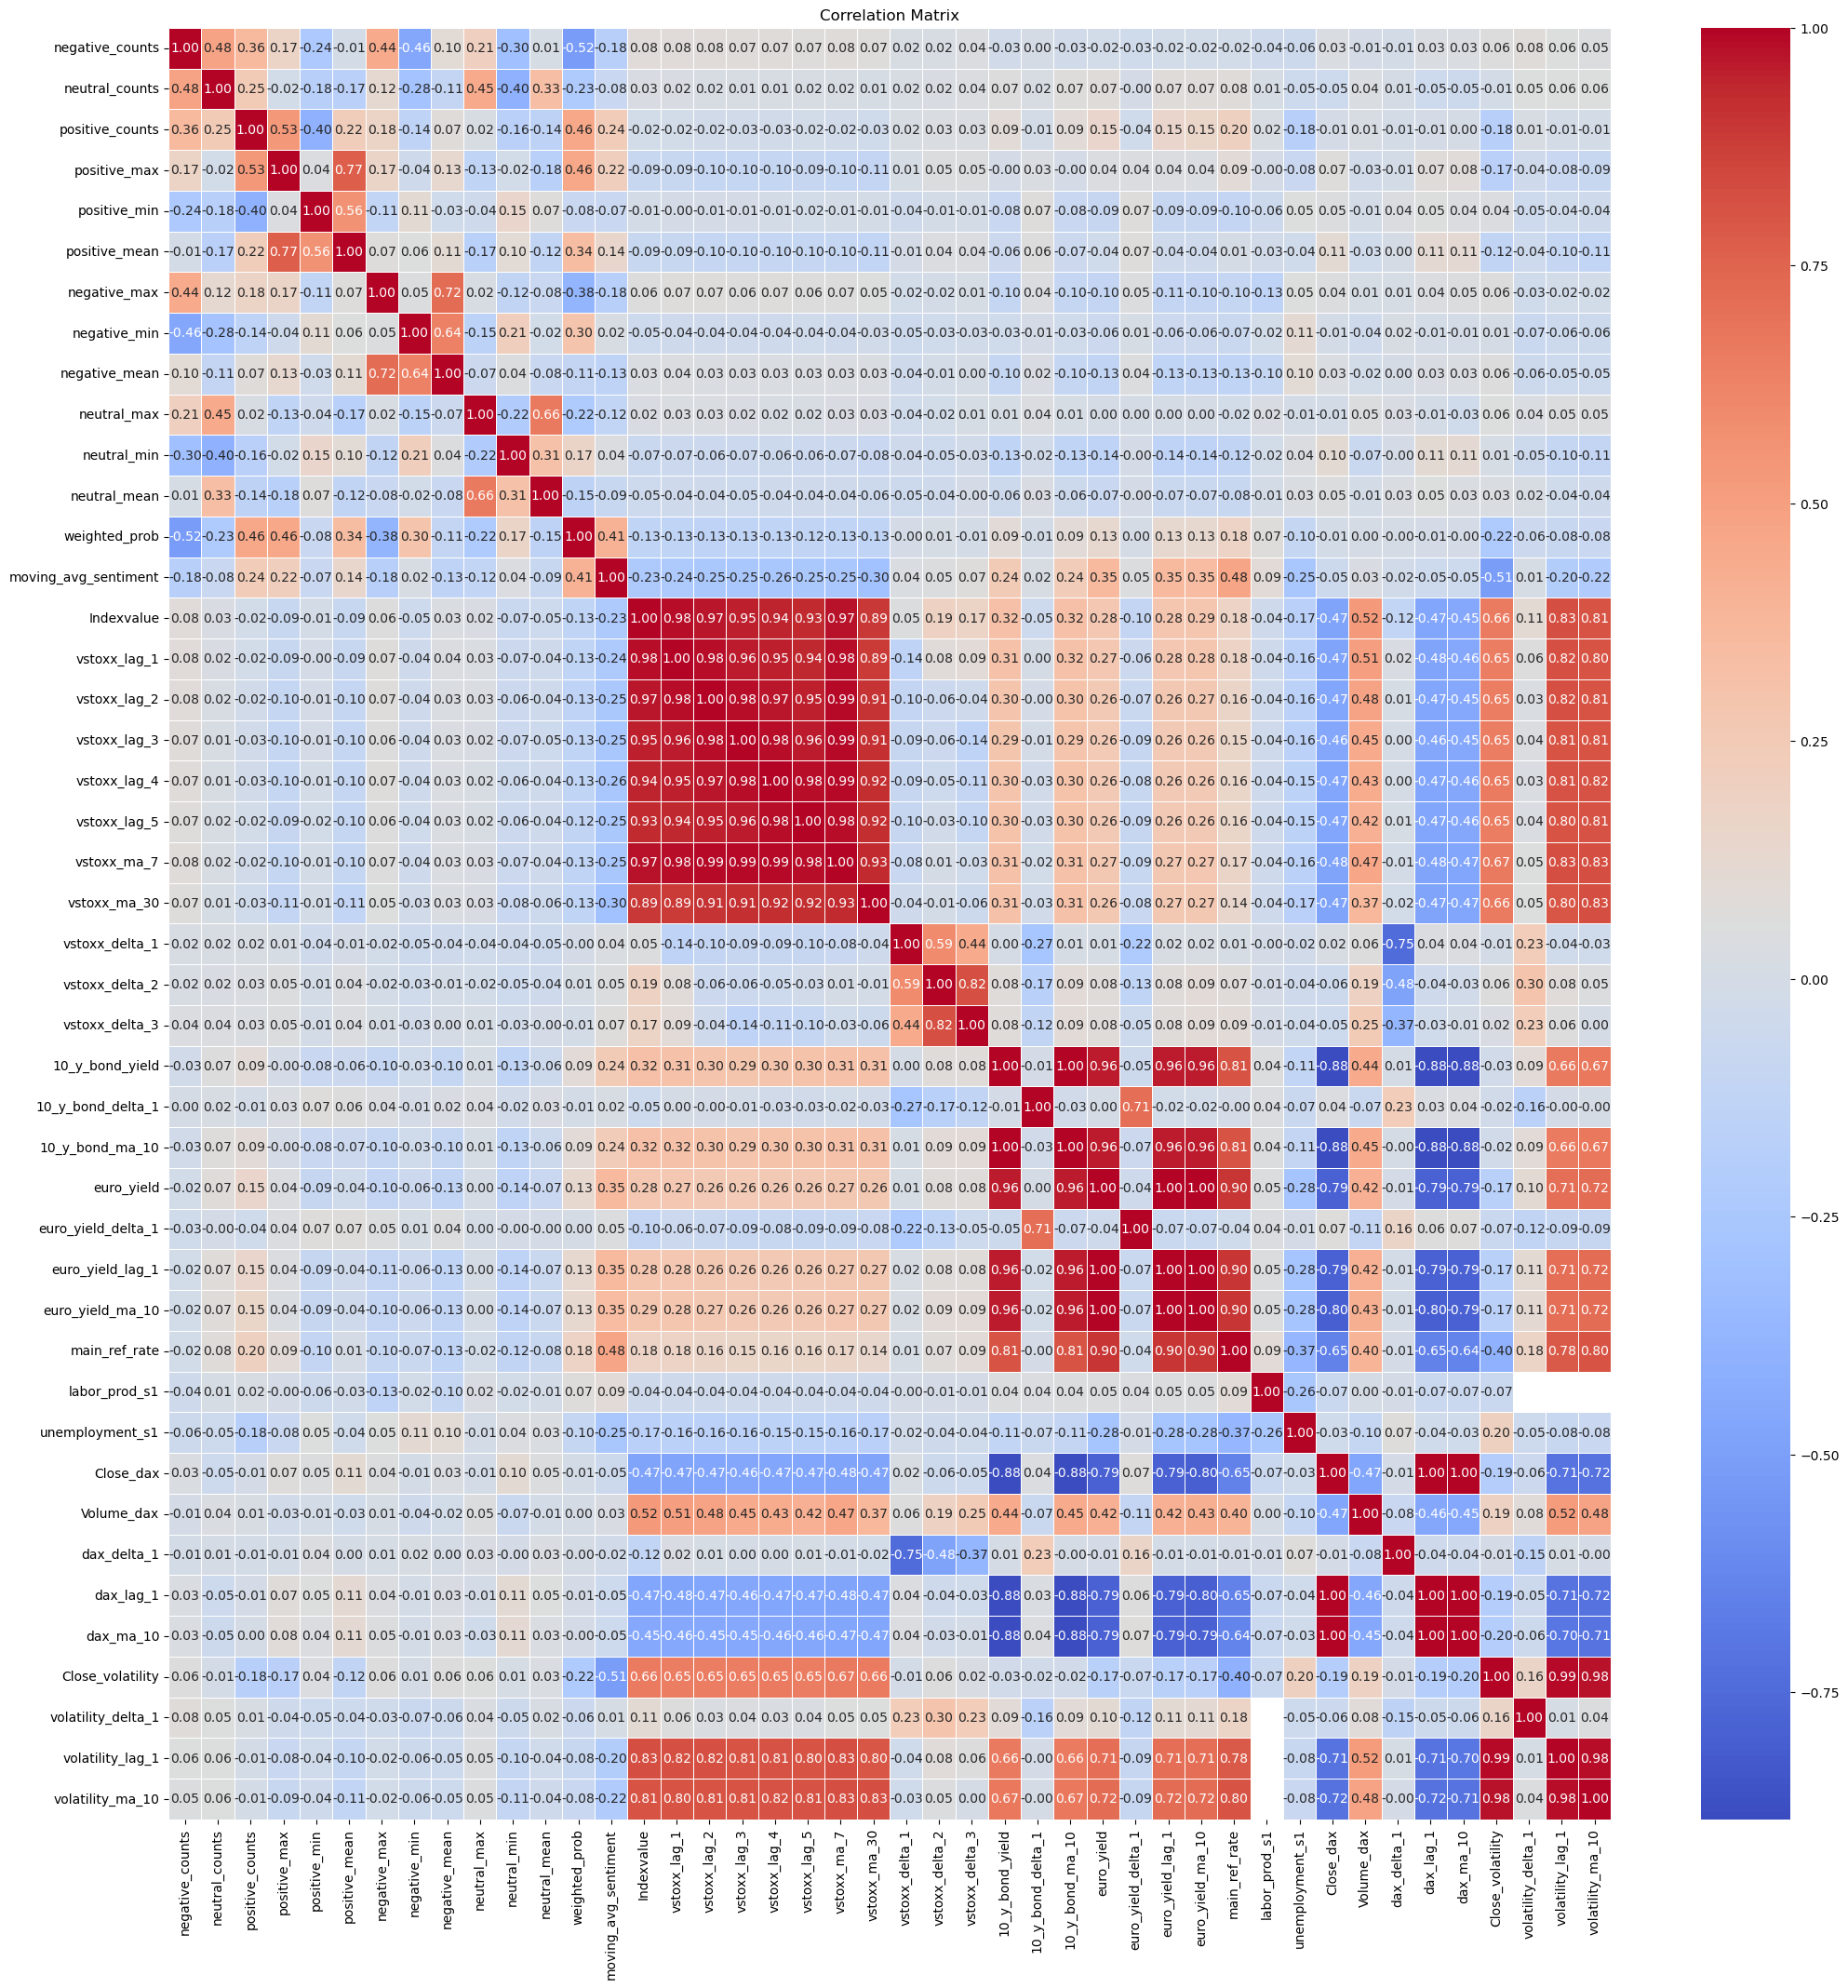

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Keep only numeric columns
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Plot the heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [24]:
# Compute correlations of each column against 'weighted_prob'
correlations = {}
for col in merged_df.columns:
    if merged_df[col].dtype in ['float64', 'int64'] and col != 'weighted_prob':
        correlations[col] = merged_df[col].corr(merged_df['weighted_prob'])

# Convert dictionary to a DataFrame for better visualization and sorting
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'Correlation_with_weighted_prob'])

# Sort by the absolute value of correlation to get a ranking
correlation_df['Abs_Correlation'] = correlation_df['Correlation_with_weighted_prob'].abs()
correlation_df = correlation_df.sort_values(by='Abs_Correlation', ascending=False).drop('Abs_Correlation', axis=1)

# Display the ranked correlations
print(correlation_df)


                Variable  Correlation_with_weighted_prob
0        negative_counts                       -0.518381
2        positive_counts                        0.462270
3           positive_max                        0.461506
12  moving_avg_sentiment                        0.409274
6           negative_max                       -0.380445
5          positive_mean                        0.344238
7           negative_min                        0.297973
1         neutral_counts                       -0.226888
9            neutral_max                       -0.224788
39      Close_volatility                       -0.223324
31         main_ref_rate                        0.176552
10           neutral_min                        0.167157
11          neutral_mean                       -0.145156
15          vstoxx_lag_2                       -0.133684
27            euro_yield                        0.130959
20          vstoxx_ma_30                       -0.130929
29      euro_yield_lag_1       

# Preparing Model I and Model II

The primary objective of this study is to assess the relevance and predictive power of the speech sentiments in certain models, as well as comparing the models themselves between each other. Each model of choice will utilize two models. For simplicity and consistency, we just call them Model I and Model II in this Notebook. 
- Dataset for Model I contains the stock market data, along with other time series data such as labor productivity, inflation, main refinancing rate.
- Dataset for Model II  has everything Model I has, and it also has speech sentiments - that is the market sentiment on the day the date indicating, as well as the moving average market sentiment of N days in the past. We chose N to be 10 in this study. 
- Based on the datasets features_1 and features_2, we will also create the further preprocessed dataframes like scaled_1 and scaled_2 that are the standardized values of the dataframes, since the models are sensitive to scale, and this prevents models from any misbehaving.

# Preparing the features_1 and features_2 datasets
- The process is simple in this case. features_2 dataset is created first, and two of the columns that are not supposed to be included in the models without sentiments will be eliminated from features_2 dataframe to create features_1 dataframe

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Extract data 
# Adding the 'weighted_prob' to the model
features_2 = merged_df[['Date','Indexvalue','10_y_bond_delta_1', 'weighted_prob', 
                        'vstoxx_lag_1','vstoxx_ma_7', 'day_of_week', 'main_ref_rate',
                        'moving_avg_sentiment','euro_yield_lag_1','Close_volatility',
                        'dax_delta_1',"dax_lag_1"]]


features_2 = features_2[features_2['day_of_week'].notna()]

# count nans
features_2.isnull().sum()
# reset index
features_2 = features_2.reset_index(drop=True)
features_2

2023-10-01 19:19:40.206196: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-01 19:19:40.207862: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-01 19:19:40.247785: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-01 19:19:40.248371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 19:19:40.996190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Date  Indexvalue  10_y_bond_delta_1  weighted_prob  vstoxx_lag_1  \
0    2005-01-26     13.3240           0.040728       0.553782       13.6280   
1    2005-02-03     12.3844           0.017255       0.527512       12.2505   
2    2005-02-28     12.8907          -0.025771       0.068567       12.2107   
3    2005-03-07     11.7178          -0.040379      -0.410220       11.9310   
4    2005-03-14     13.3498           0.007082       0.728174       12.9566   
...         ...         ...                ...            ...           ...   
1086 2022-01-21     24.2217          -0.038019       0.637534       20.4033   
1087 2022-02-04     26.3008           0.060854       0.033995       24.3287   
1088 2022-02-10     21.8414           0.031369      -0.068289       21.4117   
1089 2022-02-17     28.7931          -0.028350       0.159978       26.6138   
1090 2022-02-23     33.4572          -0.014847       0.385197       32.9766   

      vstoxx_ma_7 day_of_week  main_ref_rate  moving_avg_sentiment  \
0       13.714586   Wednesday           4.25              0.285913   
1       12.615371    Thursday           4.25              0.280547   
2       13.145800      Monday           4.25              0.249022   
3       12.361671      Monday           4.25              0.185070   
4       12.566014      Monday           4.25              0.230004   
...           ...         ...            ...                   ...   
1086    21.262686      Friday           0.00              0.122252   
1087    25.972343      Friday           0.00              0.109810   
1088    23.417500    Thursday           0.00              0.100805   
1089    25.776200    Thursday           0.00              0.136591   
1090    30.912443   Wednesday           0.00              0.130582   

      euro_yield_lag_1  Close_volatility  dax_delta_1     dax_lag_1  
0             2.752330              0.00   -19.830078   4233.950195  
1             2.803031              0.00   -14.669922   4296.310059  
2             2.991942              0.00     1.850097   4348.640137  
3             2.901090              0.00     4.569824   4423.520020  
4             2.918348              0.00     6.809571   4360.490234  
...                ...               ...          ...           ...  
1086         -0.436830              5.92  -308.450195  15912.330078  
1087         -0.143887              6.81  -268.910157  15368.469727  
1088         -0.024448              7.15     8.430664  15482.009766  
1089         -0.041497              7.57  -128.440430  15396.070313  
1090         -0.034991              7.44   -61.639648  14693.000000  

[1091 rows x 13 columns]

In [26]:
def summary_statistics_to_latex(df):
    """
    Generate summary statistics for all numeric variables in a dataframe
    and return the statistics in LaTeX table format.

    Parameters:
    - df: DataFrame

    Returns:
    - String containing the LaTeX table representation of the summary statistics
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    
    # Generate summary statistics
    summary = numeric_df.describe().transpose()
    
    # Convert to LaTeX format
    latex_table = summary.to_latex()
    
    return latex_table

print(summary_statistics_to_latex(features_2))



\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
Indexvalue & 1091.000000 & 22.974046 & 9.905301 & 10.902400 & 16.335650 & 20.623100 & 26.257750 & 78.346100 \\
10_y_bond_delta_1 & 1091.000000 & -0.002029 & 0.036824 & -0.139593 & -0.024138 & -0.002235 & 0.019261 & 0.160755 \\
weighted_prob & 1091.000000 & 0.018453 & 0.322036 & -0.743620 & -0.222341 & 0.016907 & 0.265767 & 0.728174 \\
vstoxx_lag_1 & 1091.000000 & 22.971401 & 9.991281 & 10.678300 & 16.380350 & 20.661700 & 26.205400 & 87.512700 \\
vstoxx_ma_7 & 1091.000000 & 22.957285 & 9.675404 & 11.330471 & 16.439229 & 20.896943 & 26.106979 & 76.143014 \\
main_ref_rate & 1091.000000 & 1.096334 & 1.512655 & 0.000000 & 0.000000 & 0.500000 & 1.250000 & 4.250000 \\
moving_avg_sentiment & 1091.000000 & 0.018857 & 0.127513 & -0.324196 & -0.078824 & 0.001599 & 0.105551 & 0.416147 \\
euro_yield_lag_1 & 1091.000000 & 0.961379 & 1.618142 & -0.990203 & -0.491320 & 0.380157 & 2.414192 & 4.850534 \\


In [27]:
# correlation matrix of the features_2
# Keep only numeric columns
numeric_cols = features_2.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()
correlation_matrix

Indexvalue  10_y_bond_delta_1  weighted_prob  \
Indexvalue              1.000000          -0.046096      -0.129328   
10_y_bond_delta_1      -0.046096           1.000000      -0.008166   
weighted_prob          -0.129328          -0.008166       1.000000   
vstoxx_lag_1            0.982433           0.003926      -0.127406   
vstoxx_ma_7             0.973037          -0.019590      -0.130403   
main_ref_rate           0.180813          -0.002865       0.177357   
moving_avg_sentiment   -0.230525           0.019017       0.407862   
euro_yield_lag_1        0.280805          -0.017126       0.130632   
Close_volatility        0.656676          -0.023078      -0.223122   
dax_delta_1            -0.115463           0.233894      -0.000552   
dax_lag_1              -0.471570           0.031067      -0.007252   

                      vstoxx_lag_1  vstoxx_ma_7  main_ref_rate  \
Indexvalue                0.982433     0.973037       0.180813   
10_y_bond_delta_1         0.003926    -0.019590      -0.002865   
weighted_prob            -0.127406    -0.130403       0.177357   
vstoxx_lag_1              1.000000     0.979348       0.176908   
vstoxx_ma_7               0.979348     1.000000       0.165589   
main_ref_rate             0.176908     0.165589       1.000000   
moving_avg_sentiment     -0.235276    -0.252452       0.478864   
euro_yield_lag_1          0.275560     0.271294       0.902601   
Close_volatility          0.653208     0.665984      -0.399615   
dax_delta_1               0.024793    -0.010701      -0.005788   
dax_lag_1                -0.475532    -0.478684      -0.646698   

                      moving_avg_sentiment  euro_yield_lag_1  \
Indexvalue                       -0.230525          0.280805   
10_y_bond_delta_1                 0.019017         -0.017126   
weighted_prob                     0.407862          0.130632   
vstoxx_lag_1                     -0.235276          0.275560   
vstoxx_ma_7                      -0.252452          0.271294   
main_ref_rate                     0.478864          0.902601   
moving_avg_sentiment              1.000000          0.352615   
euro_yield_lag_1                  0.352615          1.000000   
Close_volatility                 -0.513626         -0.170951   
dax_delta_1                      -0.024341         -0.012296   
dax_lag_1                        -0.051560         -0.794007   

                      Close_volatility  dax_delta_1  dax_lag_1  
Indexvalue                    0.656676    -0.115463  -0.471570  
10_y_bond_delta_1            -0.023078     0.233894   0.031067  
weighted_prob                -0.223122    -0.000552  -0.007252  
vstoxx_lag_1                  0.653208     0.024793  -0.475532  
vstoxx_ma_7                   0.665984    -0.010701  -0.478684  
main_ref_rate                -0.399615    -0.005788  -0.646698  
moving_avg_sentiment         -0.513626    -0.024341  -0.051560  
euro_yield_lag_1             -0.170951    -0.012296  -0.794007  
Close_volatility              1.000000    -0.005642  -0.194630  
dax_delta_1                  -0.005642     1.000000  -0.042473  
dax_lag_1                    -0.194630    -0.042473   1.000000

In [28]:
# store the dates for later visualization 
dates_series = features_2['Date']

# fill the euro_yield_1_day with mean of its previous and next values
features_2['10_y_bond_delta_1'] = features_2['10_y_bond_delta_1'].fillna(method='ffill')

# fill dax_delta_1 with ffill method
features_2['dax_delta_1'] = features_2['dax_delta_1'].fillna(method='ffill')

# fill dax_ma_10 with ffill method
# features_2['dax_ma_10'] = features_2['dax_ma_10'].fillna(method='ffill')

# fill dax_lag_1 with ffill method
features_2['dax_lag_1'] = features_2['dax_lag_1'].fillna(method='ffill')

# make sure there are no nan values
features_2.isnull().sum()


Date                    0
Indexvalue              0
10_y_bond_delta_1       0
weighted_prob           0
vstoxx_lag_1            0
vstoxx_ma_7             0
day_of_week             0
main_ref_rate           0
moving_avg_sentiment    0
euro_yield_lag_1        0
Close_volatility        0
dax_delta_1             0
dax_lag_1               0
dtype: int64

In [29]:
# 1. Handle the 'day_of_week' feature if it exists in your DataFrame
if 'day_of_week' in features_2.columns:
    dummies = pd.get_dummies(features_2['day_of_week'], drop_first=True)  # drop_first avoids multicollinearity
    features_2 = features_2.drop('day_of_week', axis=1)
    features_2 = pd.concat([features_2, dummies], axis=1)

In [30]:
# 2. Scale the data but exclude the 'Date' column

features_without_date_2 = features_2.drop(columns=['Date'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_without_date_2 = scaler.fit_transform(features_without_date_2)

In [31]:
# Convert the scaled data back to a DataFrame and re-add the 'Date' column
scaled2_df = pd.DataFrame(scaled_data_without_date_2, columns=features_without_date_2.columns)
scaled2_df['Date'] = dates_series.reset_index(drop=True)


In [32]:
scaled2_df

Indexvalue  10_y_bond_delta_1  weighted_prob  vstoxx_lag_1  vstoxx_ma_7  \
0       0.035906           0.600374       0.881511      0.038390     0.036785   
1       0.021974           0.522221       0.863662      0.020462     0.019825   
2       0.029481           0.378967       0.551835      0.019944     0.028009   
3       0.012090           0.330330       0.226526      0.016304     0.015911   
4       0.036288           0.488350       1.000000      0.029652     0.019063   
...          ...                ...            ...           ...          ...   
1086    0.197488           0.338188       0.938415      0.126571     0.153245   
1087    0.228315           0.667383       0.528345      0.177660     0.225911   
1088    0.162195           0.569213       0.458849      0.139695     0.186492   
1089    0.265269           0.370380       0.613944      0.207401     0.222885   
1090    0.334424           0.415338       0.766967      0.290212     0.302132   

      main_ref_rate  moving_avg_sentiment  euro_yield_lag_1  Close_volatility  \
0               1.0              0.824089          0.640764          0.000000   
1               1.0              0.816841          0.649444          0.000000   
2               1.0              0.774259          0.681788          0.000000   
3               1.0              0.687878          0.666233          0.000000   
4               1.0              0.748571          0.669188          0.000000   
...             ...                   ...               ...               ...   
1086            0.0              0.603029          0.094744          0.209706   
1087            0.0              0.586222          0.144899          0.241233   
1088            0.0              0.574059          0.165348          0.253277   
1089            0.0              0.622397          0.162429          0.268154   
1090            0.0              0.614280          0.163543          0.263549   

      dax_delta_1  dax_lag_1  Monday  Thursday  Tuesday  Wednesday       Date  
0        0.493211   0.045468     0.0       0.0      0.0        1.0 2005-01-26  
1        0.497805   0.050464     0.0       1.0      0.0        0.0 2005-02-03  
2        0.512513   0.054656     1.0       0.0      0.0        0.0 2005-02-28  
3        0.514934   0.060655     1.0       0.0      0.0        0.0 2005-03-07  
4        0.516928   0.055605     1.0       0.0      0.0        0.0 2005-03-14  
...           ...        ...     ...       ...      ...        ...        ...  
1086     0.236251   0.981068     0.0       0.0      0.0        0.0 2022-01-21  
1087     0.271454   0.937498     0.0       0.0      0.0        0.0 2022-02-04  
1088     0.518372   0.946594     0.0       1.0      0.0        0.0 2022-02-10  
1089     0.396515   0.939709     0.0       1.0      0.0        0.0 2022-02-17  
1090     0.455988   0.883383     0.0       0.0      0.0        1.0 2022-02-23  

[1091 rows x 16 columns]

In [33]:
# eliminate the 'moving_avg_sentiment_1_day' and weighted_prob columns to create scaled1_df
scaled1_df = scaled2_df.drop(columns=['moving_avg_sentiment', 'weighted_prob'])

In [34]:
scaled1_df

Indexvalue  10_y_bond_delta_1  vstoxx_lag_1  vstoxx_ma_7  main_ref_rate  \
0       0.035906           0.600374      0.038390     0.036785            1.0   
1       0.021974           0.522221      0.020462     0.019825            1.0   
2       0.029481           0.378967      0.019944     0.028009            1.0   
3       0.012090           0.330330      0.016304     0.015911            1.0   
4       0.036288           0.488350      0.029652     0.019063            1.0   
...          ...                ...           ...          ...            ...   
1086    0.197488           0.338188      0.126571     0.153245            0.0   
1087    0.228315           0.667383      0.177660     0.225911            0.0   
1088    0.162195           0.569213      0.139695     0.186492            0.0   
1089    0.265269           0.370380      0.207401     0.222885            0.0   
1090    0.334424           0.415338      0.290212     0.302132            0.0   

      euro_yield_lag_1  Close_volatility  dax_delta_1  dax_lag_1  Monday  \
0             0.640764          0.000000     0.493211   0.045468     0.0   
1             0.649444          0.000000     0.497805   0.050464     0.0   
2             0.681788          0.000000     0.512513   0.054656     1.0   
3             0.666233          0.000000     0.514934   0.060655     1.0   
4             0.669188          0.000000     0.516928   0.055605     1.0   
...                ...               ...          ...        ...     ...   
1086          0.094744          0.209706     0.236251   0.981068     0.0   
1087          0.144899          0.241233     0.271454   0.937498     0.0   
1088          0.165348          0.253277     0.518372   0.946594     0.0   
1089          0.162429          0.268154     0.396515   0.939709     0.0   
1090          0.163543          0.263549     0.455988   0.883383     0.0   

      Thursday  Tuesday  Wednesday       Date  
0          0.0      0.0        1.0 2005-01-26  
1          1.0      0.0        0.0 2005-02-03  
2          0.0      0.0        0.0 2005-02-28  
3          0.0      0.0        0.0 2005-03-07  
4          0.0      0.0        0.0 2005-03-14  
...        ...      ...        ...        ...  
1086       0.0      0.0        0.0 2022-01-21  
1087       0.0      0.0        0.0 2022-02-04  
1088       1.0      0.0        0.0 2022-02-10  
1089       1.0      0.0        0.0 2022-02-17  
1090       0.0      0.0        1.0 2022-02-23  

[1091 rows x 14 columns]

In [35]:
# To use scaled_df for LSTM sequences, remove the 'Date' column again
scaled_data_1 = scaled1_df.drop(columns=['Date']).values
scaled_data_2 = scaled2_df.drop(columns=['Date']).values

# Define the sequence length
sequence_length = 30

# Initialize lists to store the X and y data for both models
X_1 = []
y_1 = []
X_2 = []
y_2 = []

for i in range(sequence_length, len(scaled_data_1)):
    X_1.append(scaled_data_1[i-sequence_length:i, 1:])  # All columns except the target (assuming the target is in the 0th column)
    y_1.append(scaled_data_1[i, 0])  # Target column

for i in range(sequence_length, len(scaled_data_2)):
    X_2.append(scaled_data_2[i-sequence_length:i, 1:])  # All columns except the target (assuming the target is in the 0th column)
    y_2.append(scaled_data_2[i, 0])  # Target column

# Adjust the reshaping step to consider all features dynamically
num_features_1 = scaled_data_1.shape[1] - 1  # Subtracting 1 for the target column
num_features_2 = scaled_data_2.shape[1] - 1  # Subtracting 1 for the target column

# Convert the lists to numpy arrays
X_1, y_1, X_2, y_2 = np.array(X_1), np.array(y_1), np.array(X_2), np.array(y_2)

# Reshape the data
X_1 = np.reshape(X_1, (-1, sequence_length, num_features_1))
X_2 = np.reshape(X_2, (-1, sequence_length, num_features_2))

In [36]:
# make sure the number of features is correct
num_features_1, num_features_2

(12, 14)

In [37]:
# Display the shapes of the data
X_1.shape, y_1.shape, X_2.shape, y_2.shape

((1061, 30, 12), (1061,), (1061, 30, 14), (1061,))

In the process of preparing the data for LSTM modeling, sequences suitable for time series forecasting were created. Each sequence was constructed using a specified length of prior data points.

Due to this sequencing method, the initial set of data points (equal to the sequence length) couldn't be used to form complete sequences and were therefore excluded from the final dataset.

With a chosen sequence length of 30, a reduction of 30 data points was observed. Thus, if the original dataset contained 1091 data points, it was reduced to 1061 data points after this step.

In [38]:
y_1

array([0.0805887 , 0.07849213, 0.07947073, ..., 0.16219454, 0.26526866,
       0.33442412])

In [39]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

import numpy as np
import tensorflow as tf
import random
import os
# 1. Set Python's random seed
random.seed(42)

# 2. Set Numpy's random seed
np.random.seed(42)

# 3. Set TensorFlow's random seed
tf.random.set_seed(42)

# If you're using a GPU, set deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Assuming 'features' and 'targets' are already created and split as X and y, respectively.

# Split data (70% train, 30% test)
train_size = int(0.7 * len(dates_series))

# training and testing data for model 1
X_train_1, X_test_1 = X_1[:train_size], X_1[train_size:]
y_train_1, y_test_1 = y_1[:train_size], y_2[train_size:]

# training and testing data for model 2
X_train_2, X_test_2 = X_2[:train_size], X_2[train_size:]
y_train_2, y_test_2 = y_2[:train_size], y_2[train_size:]



In [40]:
X_train_1.shape, X_test_1.shape, y_train_1.shape, y_test_1.shape

((763, 30, 12), (298, 30, 12), (763,), (298,))

In [41]:
X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape

((763, 30, 14), (298, 30, 14), (763,), (298,))

In [42]:
dates_train = dates_series[:train_size].reset_index(drop=True)
dates_test = dates_series[train_size:].reset_index(drop=True)

# save the dates
dates_train = dates_series[:train_size]
dates_test = dates_series[train_size:]
dates_train, dates_test

(0     2005-01-26
 1     2005-02-03
 2     2005-02-28
 3     2005-03-07
 4     2005-03-14
          ...    
 758   2016-07-21
 759   2016-08-05
 760   2016-08-29
 761   2016-09-01
 762   2016-09-15
 Name: Date, Length: 763, dtype: datetime64[ns],
 763    2016-09-26
 764    2016-10-17
 765    2016-10-26
 766    2016-10-31
 767    2016-11-08
           ...    
 1086   2022-01-21
 1087   2022-02-04
 1088   2022-02-10
 1089   2022-02-17
 1090   2022-02-23
 Name: Date, Length: 328, dtype: datetime64[ns])

The above process makes sure that training and test data for the models are built correctly ensuring the number of features, order, time series indicator and outcome variables are stored properly.
 

# Kicking off with models
## LSTM Model I 

In [43]:
# set the optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, clipnorm=0.9,beta_1 = 0.9, beta_2 = 0.90, epsilon=1e-08, amsgrad=False) 
# rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')

# Build LSTM model
model_1_LSTM = Sequential()
model_1_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, num_features_1))) # Use num_features instead of 4
model_1_LSTM.add(LSTM(units=50))
model_1_LSTM.add(Dense(units=1))
model_1_LSTM.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Train the model and store its history
history_1_LSTM = model_1_LSTM.fit(X_train_1, y_train_1, epochs=100, batch_size=64, validation_data=(X_test_1, y_test_1))

# Access training and validation loss (can be plotted or analyzed further)
training_loss_1_LSTM = history_1_LSTM.history['loss']
validation_loss_1_LSTM = history_1_LSTM.history['val_loss']


2023-10-01 19:19:45.189150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-01 19:19:45.189872: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/100
12/12 [==============================] - 4s 90ms/step - loss: 0.0211 - val_loss: 0.0154
Epoch 2/100
12/12 [==============================] - 0s 24ms/step - loss: 0.0162 - val_loss: 0.0161
Epoch 3/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 4/100
12/12 [==============================] - 0s 24ms/step - loss: 0.0139 - val_loss: 0.0144
Epoch 5/100
12/12 [==============================] - 0s 24ms/step - loss: 0.0127 - val_loss: 0.0141
Epoch 6/100
12/12 [==============================] - 0s 26ms/step - loss: 0.0118 - val_loss: 0.0137
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0110 - val_loss: 0.0135
Epoch 8/100
12/12 [==============================] - 0s 23ms/step - loss: 0.0103 - val_loss: 0.0132
Epoch 9/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0099 - val_loss: 0.0131
Epoch 10/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0095 - val_loss: 0.0130

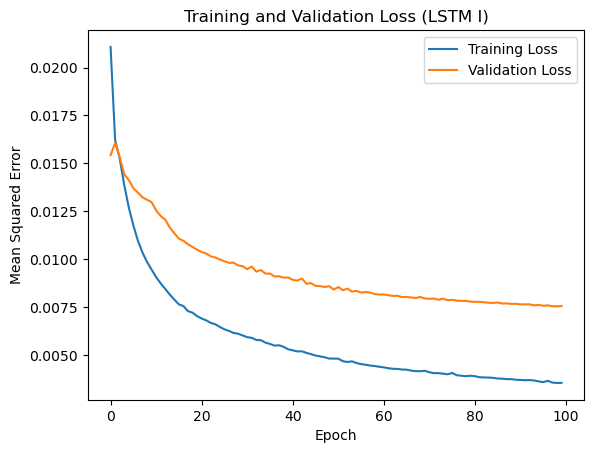

In [44]:
import matplotlib.pyplot as plt

plt.plot(training_loss_1_LSTM, label='Training Loss')
plt.plot(validation_loss_1_LSTM, label='Validation Loss')
plt.title('Training and Validation Loss (LSTM I)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [45]:

# Evaluate model
predicted_bond_price_1_LSTM = model_1_LSTM.predict(X_test_1)

num_original_features = num_features_1 + 3

# and the same number of columns as the original data
temp_array = np.zeros((predicted_bond_price_1_LSTM.shape[0], num_original_features))

# Fill the first column with `predicted_bond_price` values
temp_array[:, 0] = predicted_bond_price_1_LSTM.ravel()

# Now inverse transform this array
inverse_transformed = scaler.inverse_transform(temp_array)

# Extract the index_price predictions from the first column
final_predicted_index_price_1_LSTM = inverse_transformed[:, 0]


10/10 [==============================] - 1s 6ms/step


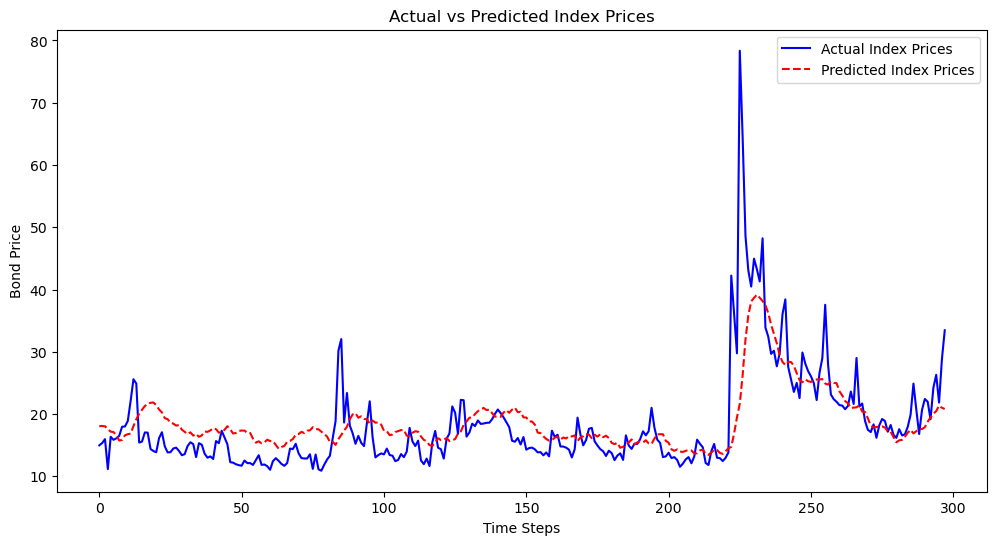

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Preparing the data for inverse transformation
# ----------------------------------------------

# Convert y_test to a 2D array for compatibility with the transformation process
y_test_2d = y_test_1.reshape(-1, 1)

# Number of original features minus 'Date'
# num_original_features = 25

# Create a placeholder array with adjusted size
placeholder_array = np.zeros((y_test_2d.shape[0], num_features_1 + 3))

# Assign the bond prices from y_test to the first column of this placeholder array.
placeholder_array[:, 0] = y_test_2d.ravel()

# Step 2: Performing the inverse transformation
# ----------------------------------------------
actual_prices = scaler.inverse_transform(placeholder_array)[:, 0]

# Step 3: Plotting the actual vs predicted bond prices
# ----------------------------------------------------

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Index Prices", color='blue')
plt.plot(final_predicted_index_price_1_LSTM, label="Predicted Index Prices", color='red', linestyle='dashed')
plt.legend()
plt.title("Actual vs Predicted Index Prices")
plt.xlabel("Time Steps")
plt.ylabel("Bond Price")
plt.show()


In [47]:
test_mse_1_LSTM = model_1_LSTM.evaluate(X_test_1, y_test_1, verbose=0)
print(f"Mean Squared Error on validation set (scaled): {test_mse_1_LSTM}")


Mean Squared Error on validation set (scaled): 0.007553070783615112


In [48]:
# Calculate RMSE from the given MSE
rmse_standardized_1_LSTM = np.sqrt(test_mse_1_LSTM)

# Create a dummy array with this RMSE value in the first column and zeros elsewhere
rmse_array_standardized_1_LSTM = np.zeros((1, num_features_1 + 3))
rmse_array_standardized_1_LSTM[0, 0] = rmse_standardized_1_LSTM

# Now inverse transform this array
rmse_real_value_array = scaler.inverse_transform(rmse_array_standardized_1_LSTM)

# Extract the RMSE in real value terms
rmse_real_value_1_LSTM = rmse_real_value_array[0, 0]
print(f"Root Mean Squared Error on validation set (inverse transformed) LSTM I: {rmse_real_value_1_LSTM}")



Root Mean Squared Error on validation set (inverse transformed) LSTM I: 16.76382436479807


In [49]:
mse_1_LSTM = history_1_LSTM.history['val_loss'][-1]  # Taking the last value from the validation loss
standard_error_1_LSTM = np.sqrt(mse_1_LSTM)
confidence_margin = 1.96 * standard_error_1_LSTM

# Convert y_train to a 2D array for compatibility
y_train_2d = y_train_1.reshape(-1, 1)

# Create a placeholder array for y_train with adjusted size
placeholder_array_train = np.zeros((y_train_2d.shape[0], num_original_features))

# Assign the bond prices from y_train to the first column of this placeholder array
placeholder_array_train[:, 0] = y_train_2d.ravel()

# Perform the inverse transformation
actual_train_prices = scaler.inverse_transform(placeholder_array_train)[:, 0]

predicted_train_index_price_1_LSTM = model_1_LSTM.predict(X_train_1)

# Create a dummy array for inverse transformation
temp_array_train = np.zeros((predicted_train_index_price_1_LSTM.shape[0], num_original_features))

# Fill the first column with `predicted_train_bond_price` values
temp_array_train[:, 0] = predicted_train_index_price_1_LSTM.ravel()

# Now inverse transform this array
inverse_transformed_train_1_LSTM = scaler.inverse_transform(temp_array_train)

# Extract the bond_price predictions for the training set
final_predicted_train_index_price_1_LSTM = inverse_transformed_train_1_LSTM[:, 0]


24/24 [==============================] - 0s 9ms/step


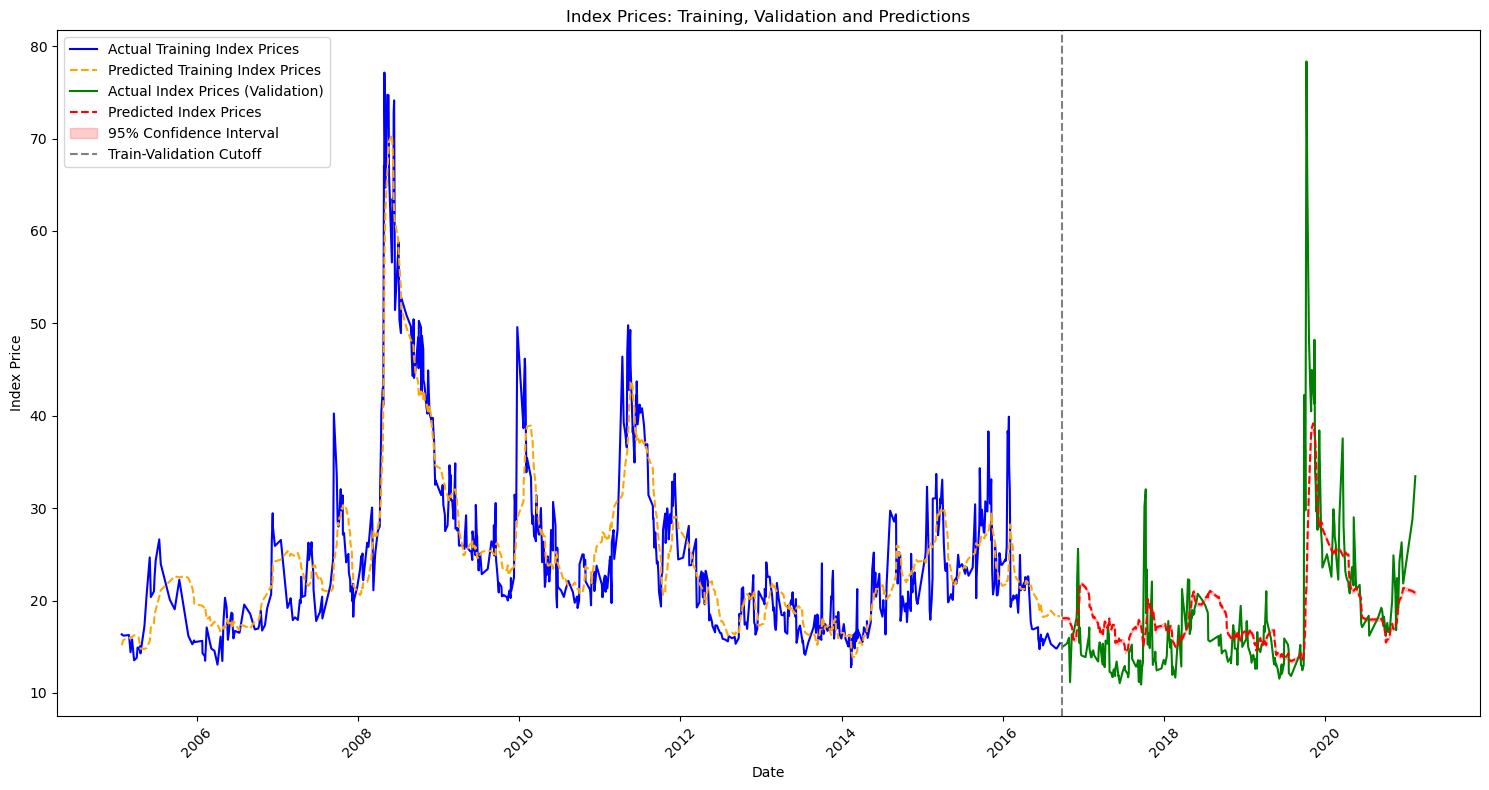

In [50]:
plt.figure(figsize=(15, 8))

# Plotting the training data with actual_train_prices
plt.plot(dates_series[:len(actual_train_prices)], actual_train_prices, label="Actual Training Index Prices", color='blue')

# Plotting the predicted index prices for the training set
plt.plot(dates_series[:len(final_predicted_train_index_price_1_LSTM)], final_predicted_train_index_price_1_LSTM, label="Predicted Training Index Prices", color='orange', linestyle='dashed')

# Plotting the validation data (actual prices)
plt.plot(dates_series[len(actual_train_prices):len(actual_train_prices) + len(y_test_1)], actual_prices, label="Actual Index Prices (Validation)", color='green')

# Plotting the predicted prices
plt.plot(dates_series[len(y_train_2d):len(y_train_2d) + len(y_test_1)], final_predicted_index_price_1_LSTM, label="Predicted Index Prices", color='red', linestyle='dashed')

# Shading the 95% confidence interval
plt.fill_between(dates_series[len(y_train_2d):len(y_train_2d) + len(y_test_1)], 
                 (final_predicted_index_price_1_LSTM - confidence_margin), 
                 (final_predicted_index_price_1_LSTM + confidence_margin), 
                 color='red', 
                 alpha=0.2,
                 label='95% Confidence Interval')

# Highlighting the training-validation cutoff
plt.axvline(x=dates_series[len(y_train_2d)], color='grey', linestyle='--', label="Train-Validation Cutoff")

plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.legend()
plt.title("Index Prices: Training, Validation and Predictions")
plt.xlabel("Date")
plt.ylabel("Index Price")
plt.tight_layout()
plt.show()


In [51]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



def build_model(lstm_units=50, optimizer=None, dropout_rate=0.0, sequence_length=None, num_features=None):
    model = Sequential()
    
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=1))
    
    # Use the optimizer passed in directly
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

def clone_optimizer(optimizer):
    config = optimizer.get_config()
    return type(optimizer)(**config)


In [52]:
# Define the hyperparameter grid
lstm_units_options = [30, 50, 70]


# set the optimizers with different learning rates
optimizers = [Adam(learning_rate=0.001), Adam(learning_rate=0.0005),
              SGD(learning_rate=0.001),SGD(learning_rate=0.0005),
              RMSprop(learning_rate=0.001), RMSprop(learning_rate=0.0005)]

# set experimental dropout rates
dropout_rates = [0.1, 0.15  ,0.2, 0.25, 0.3]

# Use grid search for hyperparameter tuning
best_val_loss = float('inf')
best_params = {}

for lstm_units in lstm_units_options:
    for optimizer in optimizers:
        for dropout_rate in dropout_rates:
            # to distinguish between the same optimizers with different learning rates
            optimizer_name = type(optimizer).__name__
            learning_rate = optimizer.get_config()['learning_rate']
            
            optimizer_id = f"{optimizer_name}_lr={learning_rate}"
            optimizer = clone_optimizer(optimizer)
            model = build_model(lstm_units=lstm_units, optimizer=optimizer, dropout_rate=dropout_rate, sequence_length=sequence_length, num_features=num_features_1)
            
            # adding early stopping and reduce learning rate on plateau
            early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)
            
            history = model.fit(X_train_1, y_train_1, epochs=50, batch_size=100, validation_data=(X_test_1, y_test_1), callbacks=[early_stopping, reduce_lr], verbose=0)
            
            # Get the best validation loss
            val_loss = min(history.history['val_loss'])
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {
                    'lstm_units': lstm_units,
                    'optimizer': optimizer,
                    'dropout_rate': dropout_rate
                }

print(f"Best validation loss: {best_val_loss}")
print("Best hyperparameters:", best_params)


Best validation loss: 0.006147157400846481
Best hyperparameters: {'lstm_units': 70, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x7f43e0619c40>, 'dropout_rate': 0.1}


In [53]:
scaled2_df

Indexvalue  10_y_bond_delta_1  weighted_prob  vstoxx_lag_1  vstoxx_ma_7  \
0       0.035906           0.600374       0.881511      0.038390     0.036785   
1       0.021974           0.522221       0.863662      0.020462     0.019825   
2       0.029481           0.378967       0.551835      0.019944     0.028009   
3       0.012090           0.330330       0.226526      0.016304     0.015911   
4       0.036288           0.488350       1.000000      0.029652     0.019063   
...          ...                ...            ...           ...          ...   
1086    0.197488           0.338188       0.938415      0.126571     0.153245   
1087    0.228315           0.667383       0.528345      0.177660     0.225911   
1088    0.162195           0.569213       0.458849      0.139695     0.186492   
1089    0.265269           0.370380       0.613944      0.207401     0.222885   
1090    0.334424           0.415338       0.766967      0.290212     0.302132   

      main_ref_rate  moving_avg_sentiment  euro_yield_lag_1  Close_volatility  \
0               1.0              0.824089          0.640764          0.000000   
1               1.0              0.816841          0.649444          0.000000   
2               1.0              0.774259          0.681788          0.000000   
3               1.0              0.687878          0.666233          0.000000   
4               1.0              0.748571          0.669188          0.000000   
...             ...                   ...               ...               ...   
1086            0.0              0.603029          0.094744          0.209706   
1087            0.0              0.586222          0.144899          0.241233   
1088            0.0              0.574059          0.165348          0.253277   
1089            0.0              0.622397          0.162429          0.268154   
1090            0.0              0.614280          0.163543          0.263549   

      dax_delta_1  dax_lag_1  Monday  Thursday  Tuesday  Wednesday       Date  
0        0.493211   0.045468     0.0       0.0      0.0        1.0 2005-01-26  
1        0.497805   0.050464     0.0       1.0      0.0        0.0 2005-02-03  
2        0.512513   0.054656     1.0       0.0      0.0        0.0 2005-02-28  
3        0.514934   0.060655     1.0       0.0      0.0        0.0 2005-03-07  
4        0.516928   0.055605     1.0       0.0      0.0        0.0 2005-03-14  
...           ...        ...     ...       ...      ...        ...        ...  
1086     0.236251   0.981068     0.0       0.0      0.0        0.0 2022-01-21  
1087     0.271454   0.937498     0.0       0.0      0.0        0.0 2022-02-04  
1088     0.518372   0.946594     0.0       1.0      0.0        0.0 2022-02-10  
1089     0.396515   0.939709     0.0       1.0      0.0        0.0 2022-02-17  
1090     0.455988   0.883383     0.0       0.0      0.0        1.0 2022-02-23  

[1091 rows x 16 columns]

## Model II LSTM 

In this section we will experiment the LSTM model with market sentiment variables

In [54]:
# set the optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, clipnorm=0.9,beta_1 = 0.9, beta_2 = 0.90, epsilon=1e-08, amsgrad=False)

# Build LSTM model
model_2_LSTM = Sequential()
model_2_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, num_features_2))) # Use num_features instead of 4
model_2_LSTM.add(LSTM(units=50))
model_2_LSTM.add(Dense(units=1))
model_2_LSTM.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and store its history
history_2_LSTM = model_2_LSTM.fit(X_train_2, y_train_2, epochs=100, batch_size=64, validation_data=(X_test_2, y_test_2))

# Access training and validation loss (can be plotted or analyzed further)
training_loss_2_LSTM = history_2_LSTM.history['loss']
validation_loss_2_LSTM = history_2_LSTM.history['val_loss']


Epoch 1/100
12/12 [==============================] - 3s 74ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 2/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0075 - val_loss: 0.0105
Epoch 3/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0061 - val_loss: 0.0084
Epoch 4/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0060 - val_loss: 0.0088
Epoch 5/100
12/12 [==============================] - 0s 30ms/step - loss: 0.0051 - val_loss: 0.0083
Epoch 6/100
12/12 [==============================] - 0s 31ms/step - loss: 0.0049 - val_loss: 0.0077
Epoch 7/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0048 - val_loss: 0.0081
Epoch 8/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0045 - val_loss: 0.0077
Epoch 9/100
12/12 [==============================] - 0s 29ms/step - loss: 0.0041 - val_loss: 0.0075
Epoch 10/100
12/12 [==============================] - 0s 29ms/step - loss: 0.0039 - val_loss: 0.0073

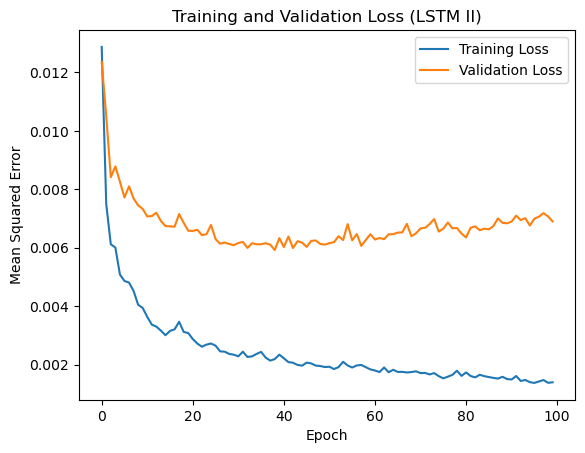

In [55]:
import matplotlib.pyplot as plt

# plot the validation and training loss

plt.plot(training_loss_2_LSTM, label='Training Loss')
plt.plot(validation_loss_2_LSTM, label='Validation Loss')
plt.title('Training and Validation Loss (LSTM II)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [56]:

# Evaluate model
predicted_index_price_2_LSTM = model_2_LSTM.predict(X_test_2)

num_original_features = 15

# Create a dummy array with the same number of rows as `predicted_bond_price`
# and the same number of columns as the original data
temp_array = np.zeros((predicted_index_price_2_LSTM.shape[0], num_original_features))

# Fill the first column with `predicted_bond_price` values
temp_array[:, 0] = predicted_index_price_2_LSTM.ravel()

# Now inverse transform this array
inverse_transformed_2_LSTM = scaler.inverse_transform(temp_array)

# Extract the bond_price predictions from the first column
final_predicted_index_price_2_LSTM = inverse_transformed_2_LSTM[:, 0]

10/10 [==============================] - 1s 5ms/step


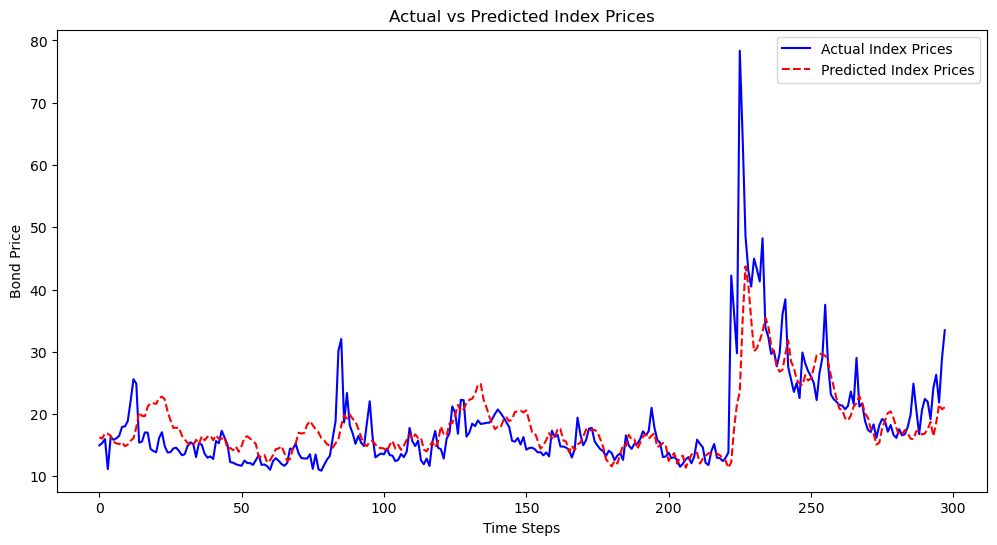

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Preparing the data for inverse transformation
# ----------------------------------------------

# Convert y_test to a 2D array for compatibility with the transformation process
y_test_2d = y_test_1.reshape(-1, 1)


# Create a placeholder array with adjusted size
placeholder_array = np.zeros((y_test_2d.shape[0], num_original_features))

# Assign the bond prices from y_test to the first column of this placeholder array.
placeholder_array[:, 0] = y_test_2d.ravel()

# Step 2: Performing the inverse transformation
# ----------------------------------------------
actual_prices = scaler.inverse_transform(placeholder_array)[:, 0]

# Step 3: Plotting the actual vs predicted bond prices
# ----------------------------------------------------

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Index Prices", color='blue')
plt.plot(final_predicted_index_price_2_LSTM, label="Predicted Index Prices", color='red', linestyle='dashed')
plt.legend()
plt.title("Actual vs Predicted Index Prices")
plt.xlabel("Time Steps")
plt.ylabel("Bond Price")
plt.show()


In [58]:
test_mse_2_LSTM = model_2_LSTM.evaluate(X_test_2, y_test_2, verbose=0)
print(f"Mean Squared Error on validation set (scaled): {test_mse_2_LSTM}")


Mean Squared Error on validation set (scaled): 0.006902528926730156


In [59]:
# Calculate RMSE from the given MSE
rmse_standardized_2_LSTM = np.sqrt(test_mse_2_LSTM)

# Create a dummy array with this RMSE value in the first column and zeros elsewhere
rmse_array_standardized_2_LSTM = np.zeros((1, num_original_features))
rmse_array_standardized_2_LSTM[0, 0] = rmse_standardized_1_LSTM

# Now inverse transform this array
rmse_real_value_array = scaler.inverse_transform(rmse_array_standardized_1_LSTM)

# Extract the RMSE in real value terms
rmse_real_value_2_LSTM = rmse_real_value_array[0, 0]
print(f"Root Mean Squared Error on validation set (inverse transformed) of LSTM II: {rmse_real_value_2_LSTM}")



Root Mean Squared Error on validation set (inverse transformed) of LSTM II: 16.76382436479807


In [60]:
mse_2_LSTM = history_2_LSTM.history['val_loss'][-1]  # Taking the last value from the validation loss
standard_error_2_LSTM = np.sqrt(mse_2_LSTM)
confidence_margin = 1.96 * standard_error_2_LSTM

# Convert y_train to a 2D array for compatibility
y_train_2d = y_train_2.reshape(-1, 1)

# Create a placeholder array for y_train with adjusted size
placeholder_array_train = np.zeros((y_train_2d.shape[0], num_original_features))

# Assign the bond prices from y_train to the first column of this placeholder array
placeholder_array_train[:, 0] = y_train_2d.ravel()

# Perform the inverse transformation
actual_train_prices = scaler.inverse_transform(placeholder_array_train)[:, 0]

predicted_train_index_price_2_LSTM = model_2_LSTM.predict(X_train_2)

# Create a dummy array for inverse transformation
temp_array_train = np.zeros((predicted_train_index_price_2_LSTM.shape[0], num_original_features))

# Fill the first column with `predicted_train_bond_price` values
temp_array_train[:, 0] = predicted_train_index_price_2_LSTM.ravel()

# Now inverse transform this array
inverse_transformed_train_2_LSTM = scaler.inverse_transform(temp_array_train)

# Extract the bond_price predictions for the training set
final_predicted_train_index_price_2_LSTM = inverse_transformed_train_1_LSTM[:, 0]


24/24 [==============================] - 0s 6ms/step


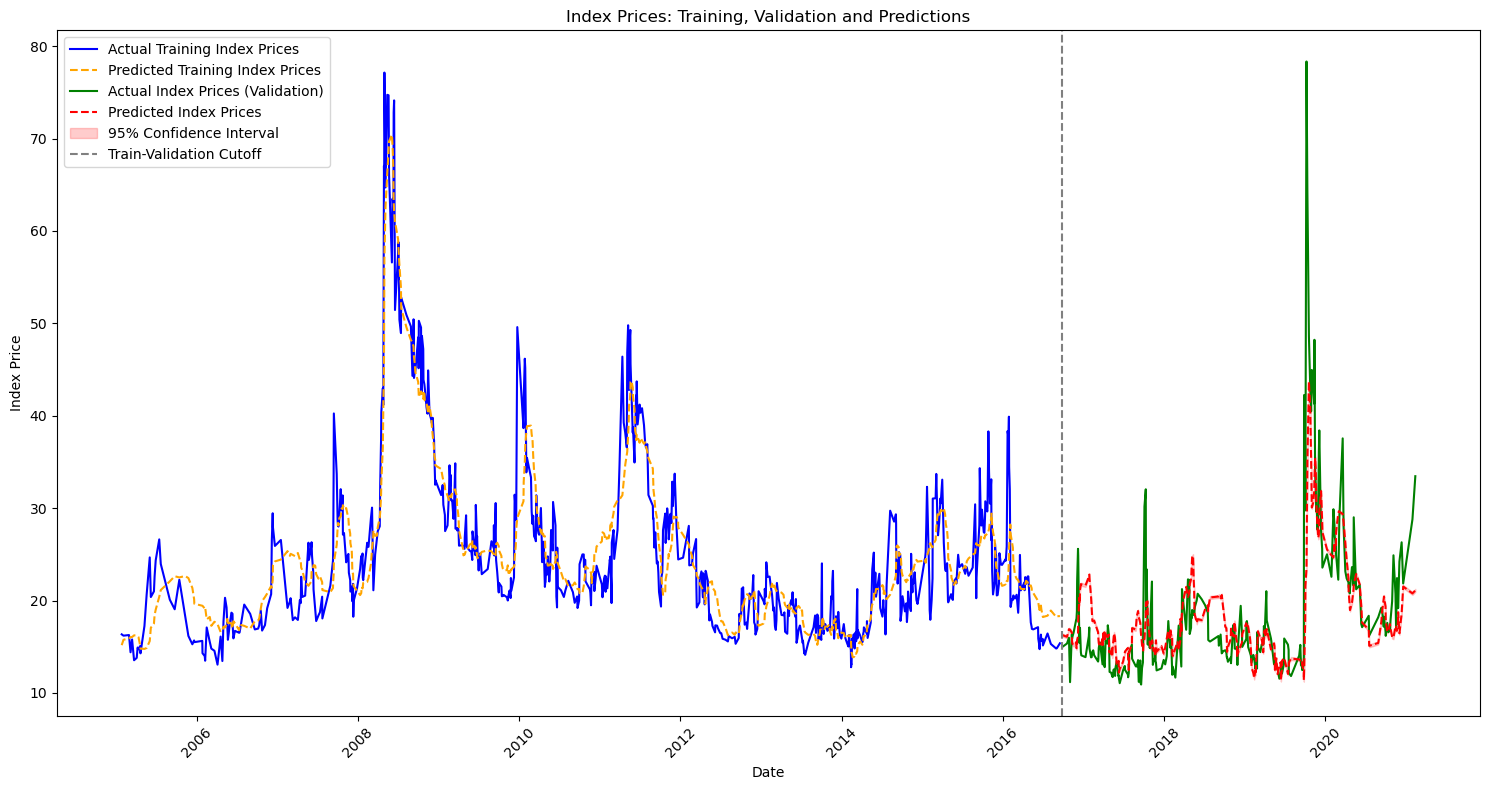

In [61]:
plt.figure(figsize=(15, 8))

# Plotting the training data with actual_train_prices
plt.plot(dates_series[:len(actual_train_prices)], actual_train_prices, label="Actual Training Index Prices", color='blue')

# Plotting the predicted index prices for the training set
plt.plot(dates_series[:len(final_predicted_train_index_price_2_LSTM)], final_predicted_train_index_price_2_LSTM, label="Predicted Training Index Prices", color='orange', linestyle='dashed')

# Plotting the validation data (actual prices)
plt.plot(dates_series[len(actual_train_prices):len(actual_train_prices) + len(y_test_2)], actual_prices, label="Actual Index Prices (Validation)", color='green')

# Plotting the predicted prices
plt.plot(dates_series[len(y_train_2d):len(y_train_2d) + len(y_test_2)], final_predicted_index_price_2_LSTM, label="Predicted Index Prices", color='red', linestyle='dashed')

# Shading the 95% confidence interval
plt.fill_between(dates_series[len(y_train_2d):len(y_train_2d) + len(y_test_2)], 
                 (final_predicted_index_price_2_LSTM - confidence_margin), 
                 (final_predicted_index_price_2_LSTM + confidence_margin), 
                 color='red', 
                 alpha=0.2,
                 label='95% Confidence Interval')

# Highlighting the training-validation cutoff
plt.axvline(x=dates_series[len(y_train_2d)], color='grey', linestyle='--', label="Train-Validation Cutoff")

plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.legend()
plt.title("Index Prices: Training, Validation and Predictions")
plt.xlabel("Date")
plt.ylabel("Index Price")
plt.tight_layout()
plt.show()


In [62]:
# Define the hyperparameter grid
lstm_units_options = [30, 50, 70]


# set the optimizers with different learning rates
optimizers = [Adam(learning_rate=0.001), Adam(learning_rate=0.0005),
              SGD(learning_rate=0.001),SGD(learning_rate=0.0005),
              RMSprop(learning_rate=0.001), RMSprop(learning_rate=0.0005)]

# set experimental dropout rates
dropout_rates = [0.1, 0.15  ,0.2, 0.25, 0.3]

# Use grid search for hyperparameter tuning
best_val_loss = float('inf')
best_params = {}

for lstm_units in lstm_units_options:
    for optimizer in optimizers:
        for dropout_rate in dropout_rates:
            # to distinguish between the same optimizers with different learning rates
            optimizer_name = type(optimizer).__name__
            learning_rate = optimizer.get_config()['learning_rate']
            
            optimizer_id = f"{optimizer_name}_lr={learning_rate}"
            optimizer = clone_optimizer(optimizer)
            model_grid_2_LSTM = build_model(lstm_units=lstm_units, optimizer=optimizer, dropout_rate=dropout_rate, sequence_length=sequence_length, num_features=num_features_2)
            
            # adding early stopping and reduce learning rate on plateau
            early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)
            
            history = model_grid_2_LSTM.fit(X_train_2, y_train_2, epochs=50, batch_size=100, validation_data=(X_test_2, y_test_2), callbacks=[early_stopping, reduce_lr], verbose=0)
            
            # Get the best validation loss
            val_loss = min(history.history['val_loss'])
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {
                    'lstm_units': lstm_units,
                    'optimizer': optimizer,
                    'dropout_rate': dropout_rate
                }

print(f"Best validation loss: {best_val_loss}")
print("Best hyperparameters:", best_params)


Best validation loss: 0.0060940030962228775
Best hyperparameters: {'lstm_units': 50, 'optimizer': <keras.src.optimizers.rmsprop.RMSprop object at 0x7f43e0e48490>, 'dropout_rate': 0.1}


# Transformers time series without sentiments

In [63]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, MultiHeadAttention, LayerNormalization, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [64]:
sequence_length = 30
num_features = 15
# the transformer model requires numeric values only, therefore we drop the date column
scaled1_t = scaled1_df.drop(columns=['Date']).values


# Prepare the data for the transformer model
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)


X_1_sequential, y_1_sequential = create_sequences(scaled1_t, sequence_length)

# Split the data into training and testing sets
train_size = int(0.7 * len(dates_series))
X_1_train_seq, X_1_test_seq = X_1_sequential[:train_size], X_1_sequential[train_size:]
y_1_train_seq, y_1_test_seq = y_1_sequential[:train_size], y_1_sequential[train_size:]



In [65]:
X_1_train_seq.shape, X_1_test_seq.shape, y_1_train_seq.shape, y_1_test_seq.shape

((763, 30, 13), (298, 30, 13), (763, 13), (298, 13))

In [66]:
scaled1_df

Indexvalue  10_y_bond_delta_1  vstoxx_lag_1  vstoxx_ma_7  main_ref_rate  \
0       0.035906           0.600374      0.038390     0.036785            1.0   
1       0.021974           0.522221      0.020462     0.019825            1.0   
2       0.029481           0.378967      0.019944     0.028009            1.0   
3       0.012090           0.330330      0.016304     0.015911            1.0   
4       0.036288           0.488350      0.029652     0.019063            1.0   
...          ...                ...           ...          ...            ...   
1086    0.197488           0.338188      0.126571     0.153245            0.0   
1087    0.228315           0.667383      0.177660     0.225911            0.0   
1088    0.162195           0.569213      0.139695     0.186492            0.0   
1089    0.265269           0.370380      0.207401     0.222885            0.0   
1090    0.334424           0.415338      0.290212     0.302132            0.0   

      euro_yield_lag_1  Close_volatility  dax_delta_1  dax_lag_1  Monday  \
0             0.640764          0.000000     0.493211   0.045468     0.0   
1             0.649444          0.000000     0.497805   0.050464     0.0   
2             0.681788          0.000000     0.512513   0.054656     1.0   
3             0.666233          0.000000     0.514934   0.060655     1.0   
4             0.669188          0.000000     0.516928   0.055605     1.0   
...                ...               ...          ...        ...     ...   
1086          0.094744          0.209706     0.236251   0.981068     0.0   
1087          0.144899          0.241233     0.271454   0.937498     0.0   
1088          0.165348          0.253277     0.518372   0.946594     0.0   
1089          0.162429          0.268154     0.396515   0.939709     0.0   
1090          0.163543          0.263549     0.455988   0.883383     0.0   

      Thursday  Tuesday  Wednesday       Date  
0          0.0      0.0        1.0 2005-01-26  
1          1.0      0.0        0.0 2005-02-03  
2          0.0      0.0        0.0 2005-02-28  
3          0.0      0.0        0.0 2005-03-07  
4          0.0      0.0        0.0 2005-03-14  
...        ...      ...        ...        ...  
1086       0.0      0.0        0.0 2022-01-21  
1087       0.0      0.0        0.0 2022-02-04  
1088       1.0      0.0        0.0 2022-02-10  
1089       1.0      0.0        0.0 2022-02-17  
1090       0.0      0.0        1.0 2022-02-23  

[1091 rows x 14 columns]

In [67]:
# Transformer block
def transformer_block(inputs, num_heads, key_dim, dropout_rate=0.1):
    # Multi-head attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    # Feed-forward neural network
    ffnn = Dense(units=128, activation='relu')(out1)  # Increase the units to 128
    ffnn = Dense(units=num_features, activation='relu')(ffnn)  # Match the output dimensions with `num_features`
    ffnn = Dropout(dropout_rate)(ffnn)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffnn)
    
    return out2

In [68]:
# Transformer model for multivariate time series forecasting
def transformer_model(sequence_length, num_features):
    # Input layer
    inputs = Input(shape=(sequence_length, num_features))
    
    # Transformer block
    transformer = transformer_block(inputs, num_heads=4, key_dim=sequence_length)
    
    # Flatten the transformer output to produce a single time step
    flattened = tf.keras.layers.Flatten()(transformer)
    
    # Output layer
    outputs = Dense(units=num_features)(flattened)
    
    # Compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [69]:
# Instantiate the model
num_features = 13
model_1_transformers = transformer_model(sequence_length, num_features=13)

# Train the model
history_1_transformers = model_1_transformers.fit(X_1_train_seq, y_1_train_seq, epochs=100, 
                                                  batch_size=64, validation_data=(X_1_test_seq, y_1_test_seq))

# Predictions
predicted_1_values_transformers = model_1_transformers.predict(X_1_test_seq)

# Create a placeholder array for predictions
placeholder_array = np.zeros((predicted_1_values_transformers.shape[0], 15))
placeholder_array[:, :13] = predicted_1_values_transformers


# inverse transform the predicted values
# inv_1_T = scaler.inverse_transform(predicted_1_values_transformers)

inv_1_T = scaler.inverse_transform(placeholder_array)

# Extract the desired predictions (e.g., bond price) from the transformed data
final_predictions_transformers_1 = inv_1_T[:, 0]

Epoch 1/100
12/12 [==============================] - 2s 30ms/step - loss: 1.2715 - val_loss: 0.5948
Epoch 2/100
12/12 [==============================] - 0s 13ms/step - loss: 0.4453 - val_loss: 0.2474
Epoch 3/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2612 - val_loss: 0.1522
Epoch 4/100
12/12 [==============================] - 0s 14ms/step - loss: 0.2152 - val_loss: 0.1234
Epoch 5/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1898 - val_loss: 0.1020
Epoch 6/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1704 - val_loss: 0.0907
Epoch 7/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1553 - val_loss: 0.0883
Epoch 8/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1463 - val_loss: 0.0843
Epoch 9/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1355 - val_loss: 0.0809
Epoch 10/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1305 - val_loss: 0.0772

In [70]:
X_1_train_seq.shape, X_1_test_seq.shape, y_1_train_seq.shape, y_1_test_seq.shape

((763, 30, 13), (298, 30, 13), (763, 13), (298, 13))

In [71]:
model_1_transformers.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 13)]             0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 30, 13)               6613      ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 dropout_360 (Dropout)       (None, 30, 13)               0         ['multi_head_attention[0][0]']
                                                                                                  
 tf.__operators__.add (TFOp  (None, 30, 13)               0         ['input_1[0][0]',         

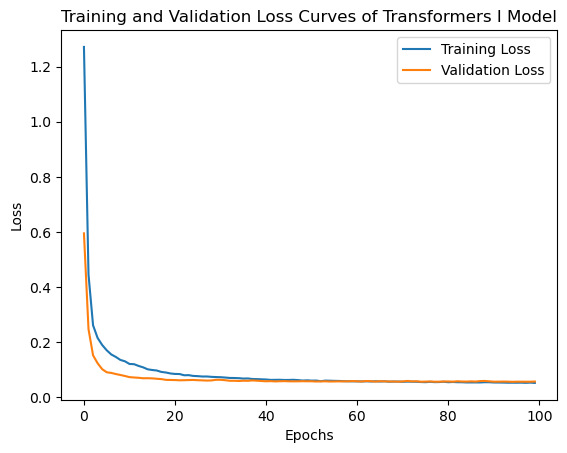

In [72]:
import matplotlib.pyplot as plt

# Extract loss and validation loss values from the history object
train_loss = history_1_transformers.history['loss']
val_loss = history_1_transformers.history['val_loss']

# Plotting
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Curves of Transformers I Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [73]:
y_1_test_seq.shape

(298, 13)

In [74]:
from sklearn.metrics import mean_squared_error

# Create a placeholder array for the actual values with the correct shape
placeholder_actual = np.zeros((y_1_test_seq.shape[0], 15))
placeholder_actual[:, :13] = y_1_test_seq
inv_actual_1_T = scaler.inverse_transform(placeholder_actual)[:, 0]

# Create a placeholder array for the predicted values with the correct shape
placeholder_predicted = np.zeros((predicted_1_values_transformers.shape[0], 15))
placeholder_predicted[:, :13] = predicted_1_values_transformers

# Compute MSE and RMSE using scaled values
mse_scaled_transformers_1 = mean_squared_error(y_1_test_seq[:, 0], scaler.transform(placeholder_predicted)[:, 0])
rmse_scaled_transformers_1 = np.sqrt(mse_scaled_transformers_1)

# Print the results
print(f"Mean Squared Error (MSE): {mse_scaled_transformers_1}")
print(f"Root Mean Squared Error (RMSE): {rmse_scaled_transformers_1}")


Mean Squared Error (MSE): 0.08696717186661726
Root Mean Squared Error (RMSE): 0.2949019699266474


/home/ozodbek/anaconda3/envs/master_thesis_env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


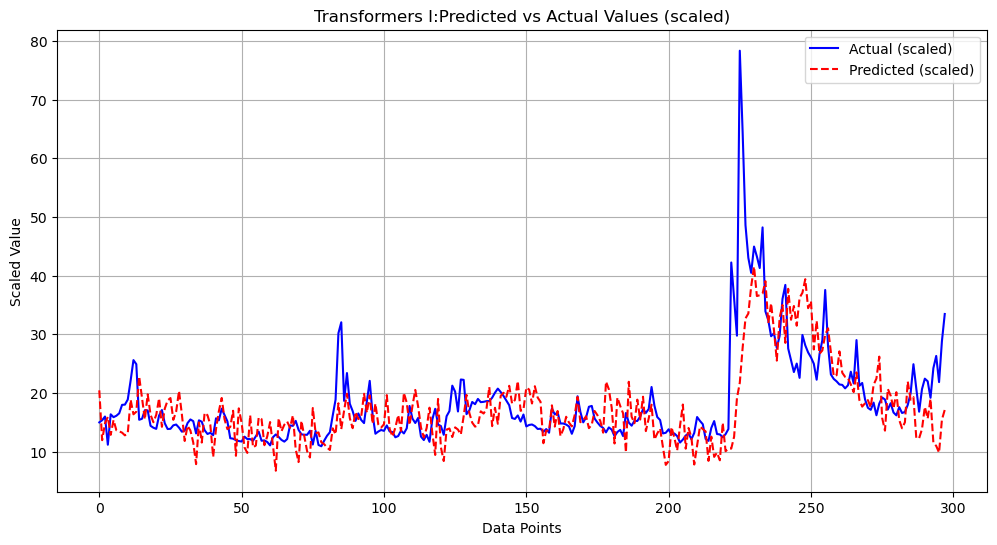

In [75]:
# Plotting Predicted vs Actual values using scaled values
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual (scaled)', color='blue')
plt.plot(final_predictions_transformers_1, label='Predicted (scaled)', color='red', linestyle='dashed')
plt.title('Transformers I:Predicted vs Actual Values (scaled)')
plt.xlabel('Data Points')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.show()

# Transformers time series with sentiments

In [76]:
sequence_length = 30
num_features = 15

X_2_sequential, y_2_sequential = create_sequences(scaled_data_2, sequence_length)

# Split the data into training and testing sets
train_size = int(0.7 * len(dates_series))
X_2_train_seq, X_2_test_seq = X_2_sequential[:train_size], X_2_sequential[train_size:]
y_2_train_seq, y_2_test_seq = y_2_sequential[:train_size], y_2_sequential[train_size:]


In [77]:
X_2_train_seq.shape, X_2_test_seq.shape, y_2_train_seq.shape, y_2_test_seq.shape

((763, 30, 15), (298, 30, 15), (763, 15), (298, 15))

In [78]:
# Instantiate the model
num_features = 15
model_2_transformers = transformer_model(sequence_length, num_features=15)

# Train the model
history_2_transformers = model_2_transformers.fit(X_2_train_seq, y_2_train_seq, epochs=100, batch_size=64,
                                                   validation_data=(X_2_test_seq, y_2_test_seq))

# Predictions
predicted_2_values_transformers = model_2_transformers.predict(X_2_test_seq)

# Create a placeholder array for predictions
placeholder_array = np.zeros((predicted_2_values_transformers.shape[0], 15))
placeholder_array[:, :15] = predicted_2_values_transformers


# inverse transform the predicted values
# inv_1_T = scaler.inverse_transform(predicted_1_values_transformers)

inv_2_T = scaler.inverse_transform(placeholder_array)

# Extract the desired predictions (e.g., bond price) from the transformed data
final_predictions_transformers_2 = inv_2_T[:, 0]

Epoch 1/100
12/12 [==============================] - 2s 32ms/step - loss: 0.9928 - val_loss: 0.4977
Epoch 2/100
12/12 [==============================] - 0s 14ms/step - loss: 0.3470 - val_loss: 0.1887
Epoch 3/100
12/12 [==============================] - 0s 15ms/step - loss: 0.2156 - val_loss: 0.1219
Epoch 4/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1815 - val_loss: 0.1047
Epoch 5/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1738 - val_loss: 0.0937
Epoch 6/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1592 - val_loss: 0.0903
Epoch 7/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1524 - val_loss: 0.0862
Epoch 8/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1440 - val_loss: 0.0815
Epoch 9/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1324 - val_loss: 0.0775
Epoch 10/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1287 - val_loss: 0.0758

In [79]:
model_2_transformers.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30, 15)]             0         []                            
                                                                                                  
 multi_head_attention_1 (Mu  (None, 30, 15)               7575      ['input_2[0][0]',             
 ltiHeadAttention)                                                   'input_2[0][0]']             
                                                                                                  
 dropout_362 (Dropout)       (None, 30, 15)               0         ['multi_head_attention_1[0][0]
                                                                    ']                            
                                                                                            

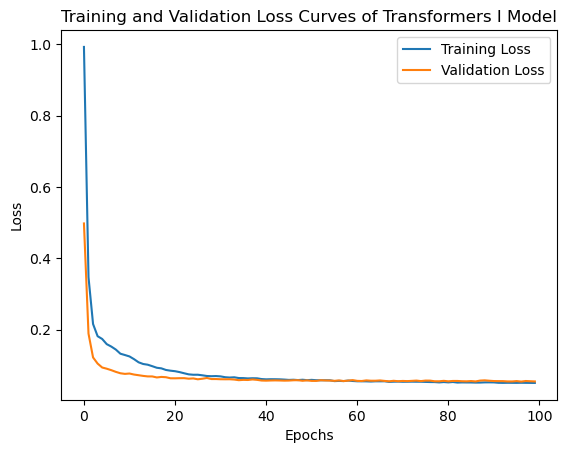

In [80]:
import matplotlib.pyplot as plt

# Extract loss and validation loss values from the history object
train_loss = history_2_transformers.history['loss']
val_loss = history_2_transformers.history['val_loss']

# Plotting
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Curves of Transformers I Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [81]:
from sklearn.metrics import mean_squared_error

# Create a placeholder array for the actual values with the correct shape
placeholder_actual = np.zeros((y_2_test_seq.shape[0], 15))
placeholder_actual[:, :15] = y_2_test_seq
inv_actual_2_T = scaler.inverse_transform(placeholder_actual)[:, 0]

# Create a placeholder array for the predicted values with the correct shape
placeholder_predicted = np.zeros((predicted_2_values_transformers.shape[0], 15))
placeholder_predicted[:, :15] = predicted_2_values_transformers

# Compute MSE and RMSE using scaled values
mse_scaled_transformers_2 = mean_squared_error(y_2_test_seq[:, 0], scaler.transform(placeholder_predicted)[:, 0])
rmse_scaled_transformers_2 = np.sqrt(mse_scaled_transformers_2)

# Print the results
print(f"Mean Squared Error (MSE): {mse_scaled_transformers_2}")
print(f"Root Mean Squared Error (RMSE): {rmse_scaled_transformers_2}")


Mean Squared Error (MSE): 0.08652096595168964
Root Mean Squared Error (RMSE): 0.2941444644246933


/home/ozodbek/anaconda3/envs/master_thesis_env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


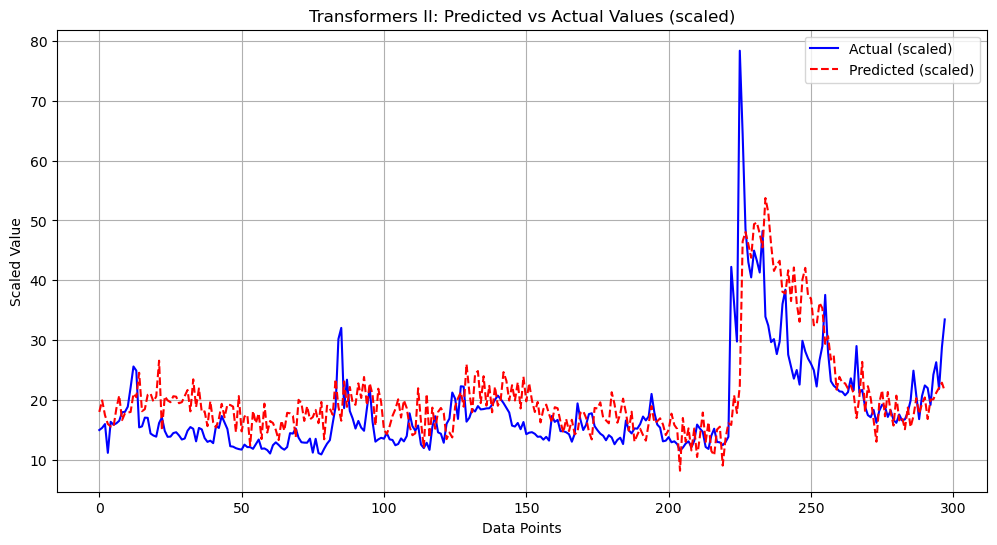

In [82]:
# Plotting Predicted vs Actual values using scaled values
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual (scaled)', color='blue')
plt.plot(final_predictions_transformers_2, label='Predicted (scaled)', color='red', linestyle='dashed')
plt.title('Transformers II: Predicted vs Actual Values (scaled)')
plt.xlabel('Data Points')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.show()

# model comparison tables and visualizations

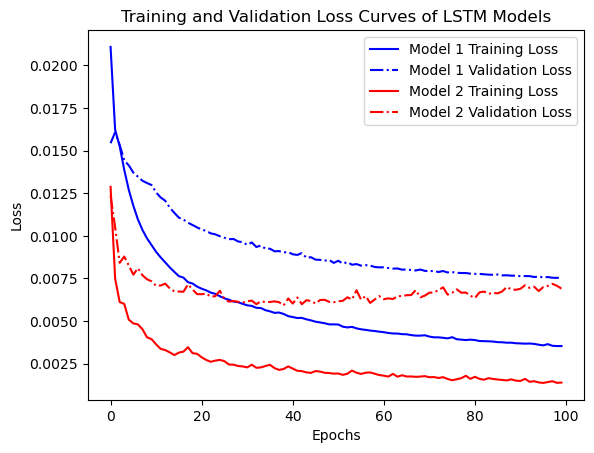

In [84]:
import matplotlib.pyplot as plt


plt.plot(training_loss_1_LSTM, label='Model 1 Training Loss', color='blue')
plt.plot(validation_loss_1_LSTM, label='Model 1 Validation Loss', color='blue', linestyle='dashdot')
plt.plot(training_loss_2_LSTM, label='Model 2 Training Loss', color='red')
plt.plot(validation_loss_2_LSTM, label='Model 2 Validation Loss', color='red', linestyle='dashdot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves of LSTM Models')
plt.show()

In [85]:
from sklearn.metrics import mean_absolute_error

mae_1 = mean_absolute_error(y_test_1, model_1_LSTM.predict(X_test_1))
mae_2 = mean_absolute_error(y_test_2, model_2_LSTM.predict(X_test_2))

# Print the results
print(f"Mean Absolute Error (MAE) of LSTM I: {mae_1}")
print(f"Mean Absolute Error (MAE) of LSTM II: {mae_2}")


10/10 [==============================] - 0s 6ms/step
Mean Absolute Error (MAE) of LSTM I: 0.051139339034665096
Mean Absolute Error (MAE) of LSTM II: 0.046485183643344426


In [86]:
residuals_1 = y_test_1 - model_1_LSTM.predict(X_test_1).ravel()
residuals_2 = y_test_2 - model_2_LSTM.predict(X_test_2).ravel()

 1/10 [==>...........................] - ETA: 0s

10/10 [==============================] - 0s 7ms/step


In [87]:
residuals_1.shape, residuals_2.shape

((298,), (298,))

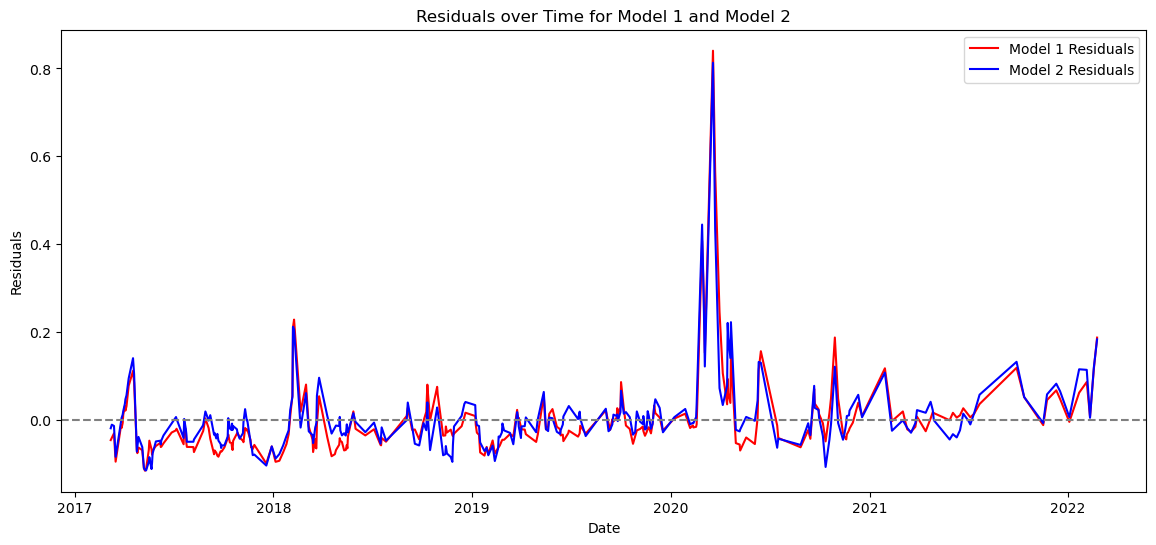

In [88]:
dates_test = dates_test[-298:]  # take the last 298 dates
plt.figure(figsize=(14, 6))

# Plot residuals for Model 1
plt.plot(dates_test, residuals_1, label='Model 1 Residuals', color='red')

# Plot residuals for Model 2
plt.plot(dates_test, residuals_2, label='Model 2 Residuals', color='blue')

# Add a horizontal line at y=0
plt.axhline(y=0, color='grey', linestyle='--')

# Labeling and titles
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.title('Residuals over Time for Model 1 and Model 2')

plt.show()


In [89]:
params_1 = model_1_LSTM.count_params()
params_2 = model_2_LSTM.count_params()
params_1 , params_2

(32851, 33251)

In [90]:
import pandas as pd

# Quantitative Metrics
data = {
    'Metric/Aspect': [
        'MSE', 
        'RMSE', 
        'MAE', 
        'Best Validation Loss', 
        'Number of LSTM Units', 
        'Dropout Rate', 
        'Optimizer Type', 
        'Number of Training Epochs',
        'Number of Parameters'
    ],
    'Model 1': [
        mse_1_LSTM,
        rmse_real_value_1_LSTM, 
        mae_1, 
        min(history_1_LSTM.history['val_loss']), 
        model_1_LSTM.layers[0].units,  # Assuming first LSTM layer for units
        "0.1",
        model_1_LSTM.optimizer.get_config()['name'],
        len(history_1_LSTM.history['loss']),
        params_1
    ],
    'Model 2': [
        mse_2_LSTM, 
        rmse_real_value_2_LSTM, 
        mae_2, 
        min(history_2_LSTM.history['val_loss']), 
        model_2_LSTM.layers[0].units, 
        "0.3",
        model_2_LSTM.optimizer.get_config()['name'],
        len(history_2_LSTM.history['loss']),
        params_2
    ]
}

# Create DataFrame
model_comparison = pd.DataFrame(data)

print(model_comparison)



               Metric/Aspect    Model 1    Model 2
0                        MSE   0.007553   0.006903
1                       RMSE  16.763824  16.763824
2                        MAE   0.051139   0.046485
3       Best Validation Loss   0.007535   0.005923
4       Number of LSTM Units         50         50
5               Dropout Rate        0.1        0.3
6             Optimizer Type       Adam       Adam
7  Number of Training Epochs        100        100
8       Number of Parameters      32851      33251


In [ ]:
latex_code = model_comparison.to_latex(index=False)
latex_code

'\\begin{tabular}{lll}\n\\toprule\nMetric/Aspect & Model 1 & Model 2 \\\\\n\\midrule\nMSE & 0.007553 & 0.006434 \\\\\nRMSE & 16.763824 & 16.763824 \\\\\nMAE & 0.051139 & 0.053211 \\\\\nBest Validation Loss & 0.007535 & 0.005835 \\\\\nNumber of LSTM Units & 50 & 50 \\\\\nDropout Rate & 0.1 & 0.3 \\\\\nOptimizer Type & Adam & Adam \\\\\nNumber of Training Epochs & 100 & 100 \\\\\nNumber of Parameters & 32851 & 33251 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
scaled1_df

Indexvalue  10_y_bond_delta_1  vstoxx_lag_1  vstoxx_ma_7  main_ref_rate  \
0       0.035906           0.600374      0.038390     0.036785            1.0   
1       0.021974           0.522221      0.020462     0.019825            1.0   
2       0.029481           0.378967      0.019944     0.028009            1.0   
3       0.012090           0.330330      0.016304     0.015911            1.0   
4       0.036288           0.488350      0.029652     0.019063            1.0   
...          ...                ...           ...          ...            ...   
1086    0.197488           0.338188      0.126571     0.153245            0.0   
1087    0.228315           0.667383      0.177660     0.225911            0.0   
1088    0.162195           0.569213      0.139695     0.186492            0.0   
1089    0.265269           0.370380      0.207401     0.222885            0.0   
1090    0.334424           0.415338      0.290212     0.302132            0.0   

      euro_yield_lag_1  Close_volatility  dax_delta_1  dax_lag_1  Monday  \
0             0.640764          0.000000     0.493211   0.045468     0.0   
1             0.649444          0.000000     0.497805   0.050464     0.0   
2             0.681788          0.000000     0.512513   0.054656     1.0   
3             0.666233          0.000000     0.514934   0.060655     1.0   
4             0.669188          0.000000     0.516928   0.055605     1.0   
...                ...               ...          ...        ...     ...   
1086          0.094744          0.209706     0.236251   0.981068     0.0   
1087          0.144899          0.241233     0.271454   0.937498     0.0   
1088          0.165348          0.253277     0.518372   0.946594     0.0   
1089          0.162429          0.268154     0.396515   0.939709     0.0   
1090          0.163543          0.263549     0.455988   0.883383     0.0   

      Thursday  Tuesday  Wednesday       Date  
0          0.0      0.0        1.0 2005-01-26  
1          1.0      0.0        0.0 2005-02-03  
2          0.0      0.0        0.0 2005-02-28  
3          0.0      0.0        0.0 2005-03-07  
4          0.0      0.0        0.0 2005-03-14  
...        ...      ...        ...        ...  
1086       0.0      0.0        0.0 2022-01-21  
1087       0.0      0.0        0.0 2022-02-04  
1088       1.0      0.0        0.0 2022-02-10  
1089       1.0      0.0        0.0 2022-02-17  
1090       0.0      0.0        1.0 2022-02-23  

[1091 rows x 14 columns]

# Variable importance and feature selection with Random forest and XGBoost
# Random forest I

In [91]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Sort the DataFrame by Date
scaled1_df = scaled1_df.sort_values(by='Date')

# Save the variable names for later use (excluding 'Date' and 'Indexvalue')
feature_names_1_rf = scaled1_df.columns[scaled1_df.columns != 'Date']
feature_names_1_rf = feature_names_1_rf[feature_names_1_rf != 'Indexvalue'].tolist()

# Drop the 'Date' column
scaled_data_1_rf = scaled1_df.drop(columns=['Date']).values

# Define the split point
split_point_rf = int(0.8 * len(scaled_data_1_rf))

# Split the data into training and test sets
train_data_1_rf = scaled_data_1_rf[:split_point_rf]
test_data_1_rf = scaled_data_1_rf[split_point_rf:]

# Separate Features and Target
X_train_1_rf = train_data_1_rf[:, 1:]
y_train_1_rf = train_data_1_rf[:, 0]

X_test_1_rf = test_data_1_rf[:, 1:]
y_test_1_rf = test_data_1_rf[:, 0]

In [92]:
feature_names_1_rf

['10_y_bond_delta_1',
 'vstoxx_lag_1',
 'vstoxx_ma_7',
 'main_ref_rate',
 'euro_yield_lag_1',
 'Close_volatility',
 'dax_delta_1',
 'dax_lag_1',
 'Monday',
 'Thursday',
 'Tuesday',
 'Wednesday']

In [93]:
# Initialize the Random Forest Regressor for the first dataset
rf_model_1_rf = RandomForestRegressor(n_estimators=200,  # Number of trees in the forest
                                      max_depth=None,     # Maximum depth of the tree
                                      min_samples_split=2,  # Minimum number of samples required to split an internal node
                                      min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node
                                      random_state=42,
                                      oob_score = True)      # Seed for reproducibility

# Train the Random Forest model on the first dataset
rf_model_1_rf.fit(X_train_1_rf, y_train_1_rf)

# Predict on the test set for the first dataset
y_pred_1_rf = rf_model_1_rf.predict(X_test_1_rf)

# Extract feature importance from the trained model
feature_importance_1_rf = rf_model_1_rf.feature_importances_

In [94]:
y_pred_1_rf.shape, y_test_1_rf.shape

((219,), (219,))

In [95]:
# Extract feature importance from the trained model
feature_importance_1_rf = rf_model_1_rf.feature_importances_
feature_importance_1_rf



array([2.17718706e-03, 8.98292300e-01, 7.98602220e-02, 4.96202063e-04,
       1.27238056e-03, 3.17446553e-03, 1.15462128e-02, 2.42343719e-03,
       3.43848451e-04, 1.86398833e-04, 1.43895871e-04, 8.34493236e-05])

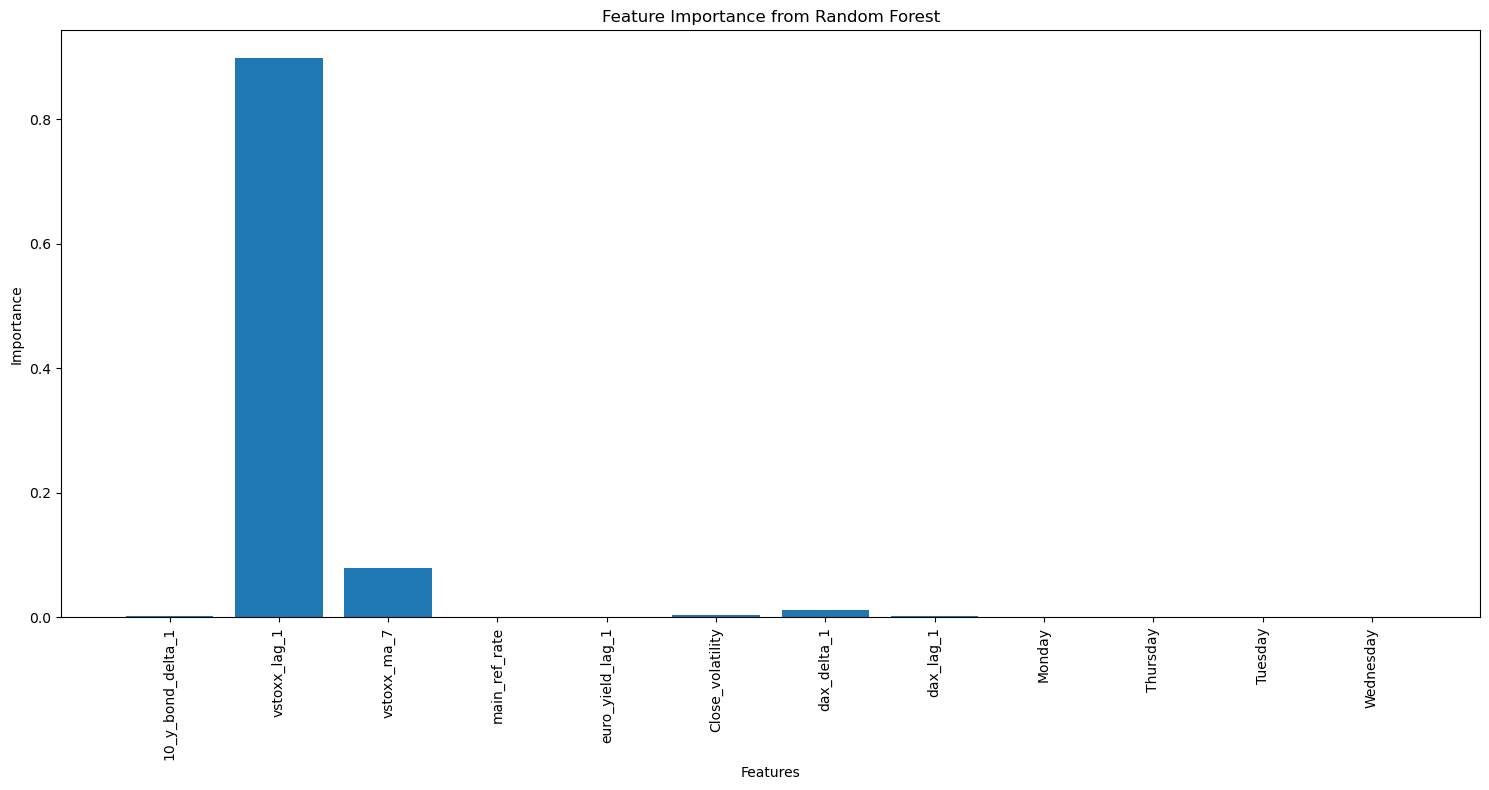

In [96]:
# Plot the feature importance
plt.figure(figsize=(15, 8))
plt.bar(feature_names_1_rf, feature_importance_1_rf)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees for better readability
plt.tight_layout()  # Adjust layout for better display
plt.show()

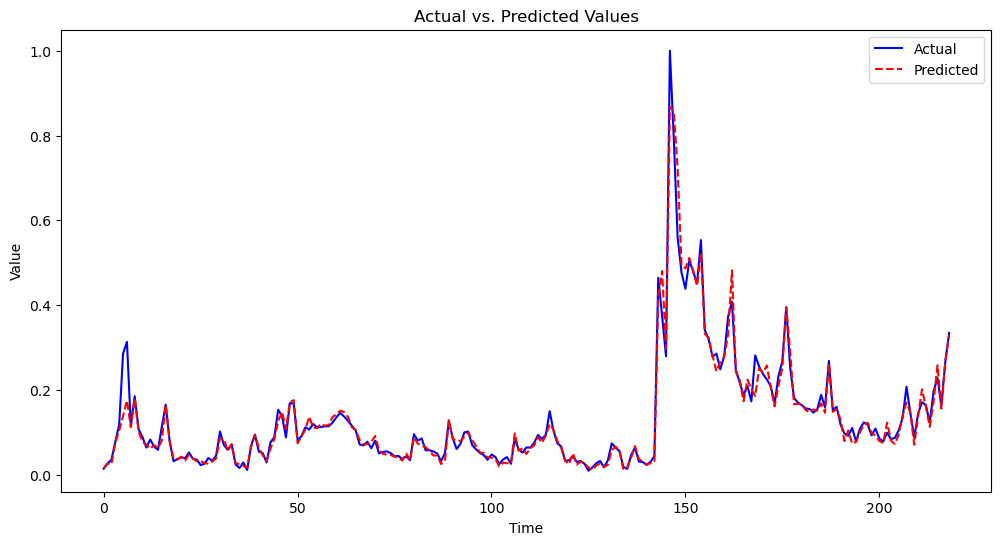

In [97]:
y_pred_1_rf.shape, y_test_1_rf.shape
# Assuming y_test_1 is the actual values for X_test_1
plt.figure(figsize=(12, 6))
plt.plot(y_test_1_rf, label='Actual', color='blue')
plt.plot(y_pred_1_rf, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()


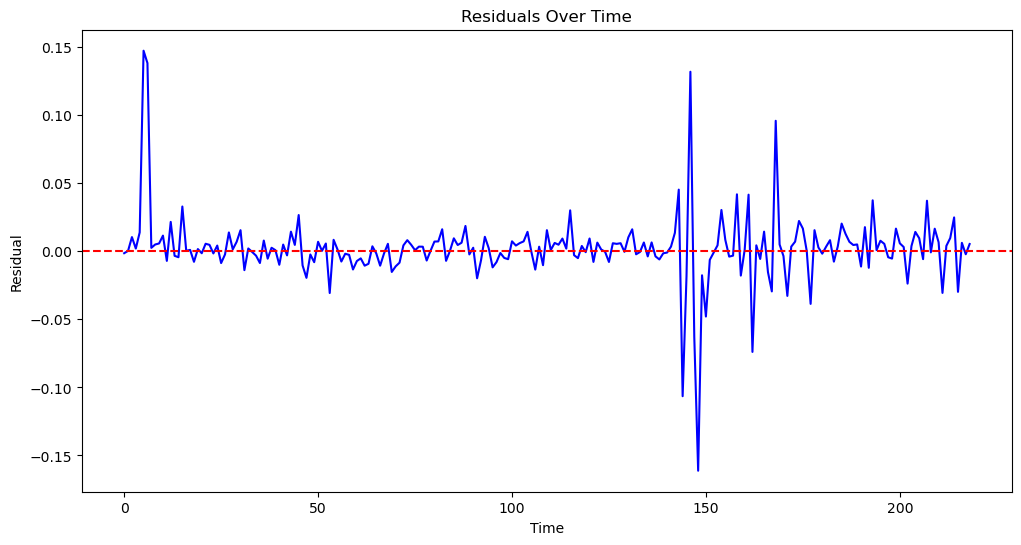

In [98]:
residuals = y_test_1_rf - y_pred_1_rf

plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.axhline(0, color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('Residuals Over Time')
plt.show()


In [99]:
oob_error = 1 - rf_model_1_rf.oob_score_
oob_error

0.01877621799191087

In [100]:
from sklearn.metrics import mean_squared_error

# Predict on the test set
y_pred_1_rf_rf = rf_model_1_rf.predict(X_test_1_rf)

# Calculate MSE
mse = mean_squared_error(y_test_1_rf, y_pred_1_rf_rf)

# Calculate RMSE
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MSE: 0.0006834524149876213
RMSE: 0.026142922847065538


# Random Forest II

In [101]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Sort the DataFrame by Date
scaled2_df = scaled2_df.sort_values(by='Date')

# Save the variable names for later use (excluding 'Date' and 'Indexvalue')
feature_names_2_rf = scaled2_df.columns[scaled2_df.columns != 'Date']
feature_names_2_rf = feature_names_2_rf[feature_names_2_rf != 'Indexvalue'].tolist()

# Drop the 'Date' column
scaled_data_2_rf = scaled2_df.drop(columns=['Date']).values

# Define the split point
split_point_rf = int(0.8 * len(scaled_data_1_rf))

# Split the data into training and test sets
train_data_2_rf = scaled_data_2_rf[:split_point_rf]
test_data_2_rf = scaled_data_2_rf[split_point_rf:]

# Separate Features and Target
X_train_2_rf = train_data_2_rf[:, 1:]
y_train_2_rf = train_data_2_rf[:, 0]

X_test_2_rf = test_data_2_rf[:, 1:]
y_test_2_rf = test_data_2_rf[:, 0]

In [102]:
# Initialize the Random Forest Regressor for the first dataset
rf_model_2 = RandomForestRegressor(n_estimators=200,  # Number of trees in the forest
                                      max_depth=None,     # Maximum depth of the tree
                                      min_samples_split=2,  # Minimum number of samples required to split an internal node
                                      min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node
                                      random_state=42,
                                      oob_score = True)      # Seed for reproducibility

# Train the Random Forest model on the first dataset
rf_model_2.fit(X_train_2_rf, y_train_2_rf)

# Predict on the test set for the first dataset
y_pred_2_rf = rf_model_2.predict(X_test_2_rf)

# Extract feature importance from the trained model
feature_importance_2_rf = rf_model_2.feature_importances_

In [103]:
y_pred_1_rf.shape, y_test_1_rf.shape

((219,), (219,))

In [104]:
# Extract feature importance from the trained model
feature_importance_2_rf = rf_model_2.feature_importances_
feature_importance_2_rf

array([1.93020851e-03, 1.11239971e-03, 8.97414436e-01, 7.95036808e-02,
       4.05273026e-04, 1.59282558e-03, 9.72779777e-04, 2.97439027e-03,
       1.11160749e-02, 2.35598103e-03, 2.86235843e-04, 1.66279767e-04,
       1.07076595e-04, 6.23578650e-05])

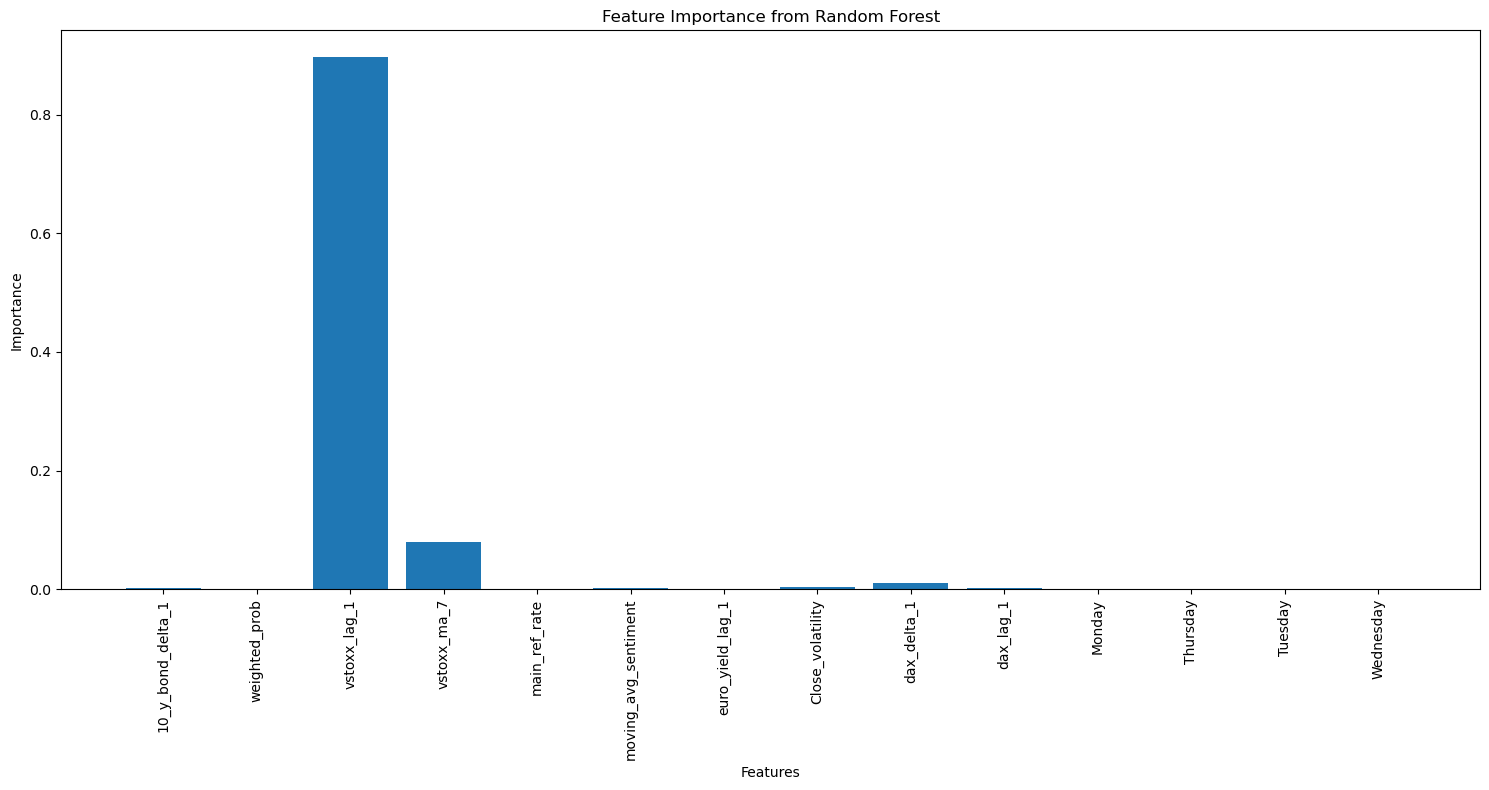

In [105]:
# Plot the feature importance
plt.figure(figsize=(15, 8))
plt.bar(feature_names_2_rf, feature_importance_2_rf)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees for better readability
plt.tight_layout()  # Adjust layout for better display
plt.show()

In [ ]:
# scatter of weighted_prob and Indexvalue
plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

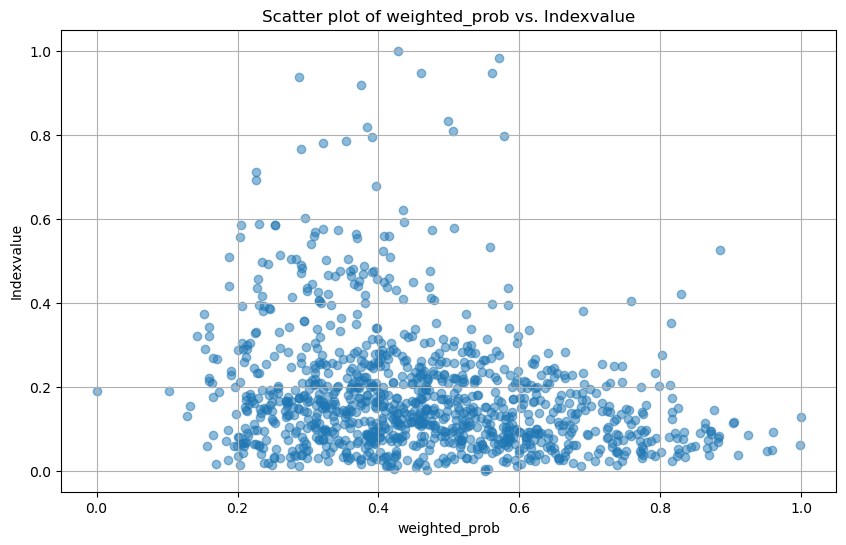

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(scaled2_df['moving_avg_sentiment'], scaled2_df['Indexvalue'], alpha=0.5)
plt.title('Scatter plot of weighted_prob vs. Indexvalue')
plt.xlabel('weighted_prob')
plt.ylabel('Indexvalue')
plt.grid(True)
plt.show()


# XGBoost

In [106]:
import xgboost as xgb

# Set random seed for reproducibility
np.random.seed(42)

# Sort the DataFrame by Date
scaled1_df = scaled1_df.sort_values(by='Date')

# Save the variable names for later use (excluding 'Date' and 'Indexvalue')
feature_names_1_xgb = scaled1_df.columns[scaled1_df.columns != 'Date']
feature_names_1_xgb = feature_names_1_xgb[feature_names_1_xgb != 'Indexvalue'].tolist()

# Drop the 'Date' column
scaled_data_1_xgb = scaled1_df.drop(columns=['Date']).values

# Define the split point
split_point_xgb = int(0.8 * len(scaled_data_1_xgb))

# Split the data into training and test sets
train_data_1_xgb = scaled_data_1_xgb[:split_point_xgb]
test_data_1_xgb = scaled_data_1_xgb[split_point_xgb:]

# Separate Features and Target
X_train_1_xgb = train_data_1_xgb[:, 1:]
y_train_1_xgb = train_data_1_xgb[:, 0]

X_test_1_xgb = test_data_1_xgb[:, 1:]
y_test_1_xgb = test_data_1_xgb[:, 0]


In [107]:
# Initialize the XGBoost Regressor
xgb_model_1 = xgb.XGBRegressor(
    n_estimators=200,  # Number of boosting rounds
    max_depth=6,       # Maximum depth of a tree
    learning_rate=0.1, # Step size shrinkage used in update to prevent overfitting
    objective='reg:squarederror', # Regression with squared loss
    random_state=42   # Seed for reproducibility
)

# Train the XGBoost model on the first dataset
xgb_model_1.fit(X_train_1_xgb, y_train_1_xgb)

# Predict on the test set for the first dataset
y_pred_1_xgb = xgb_model_1.predict(X_test_1_xgb)


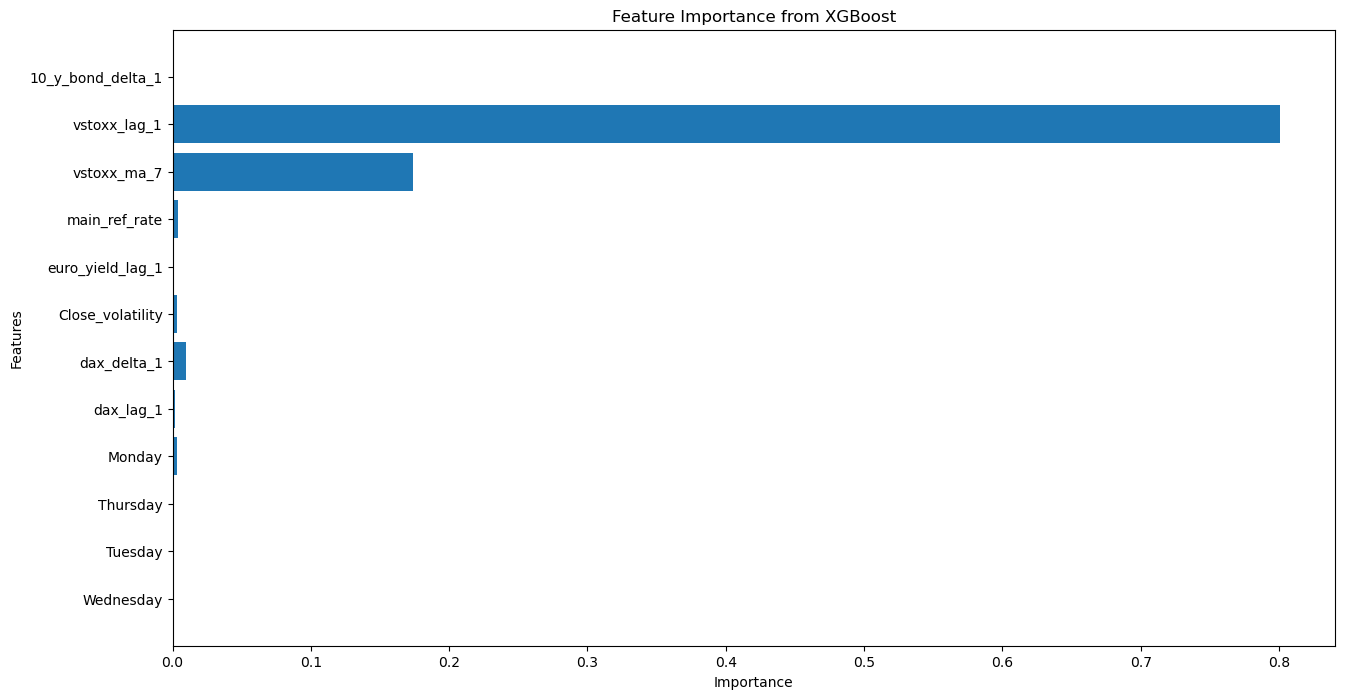

In [108]:
# Extract feature importances
feature_importance_xgb = xgb_model_1.feature_importances_

# Plot feature importances
plt.figure(figsize=(15, 8))
plt.barh(feature_names_1_xgb, feature_importance_xgb, align='center')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.show()


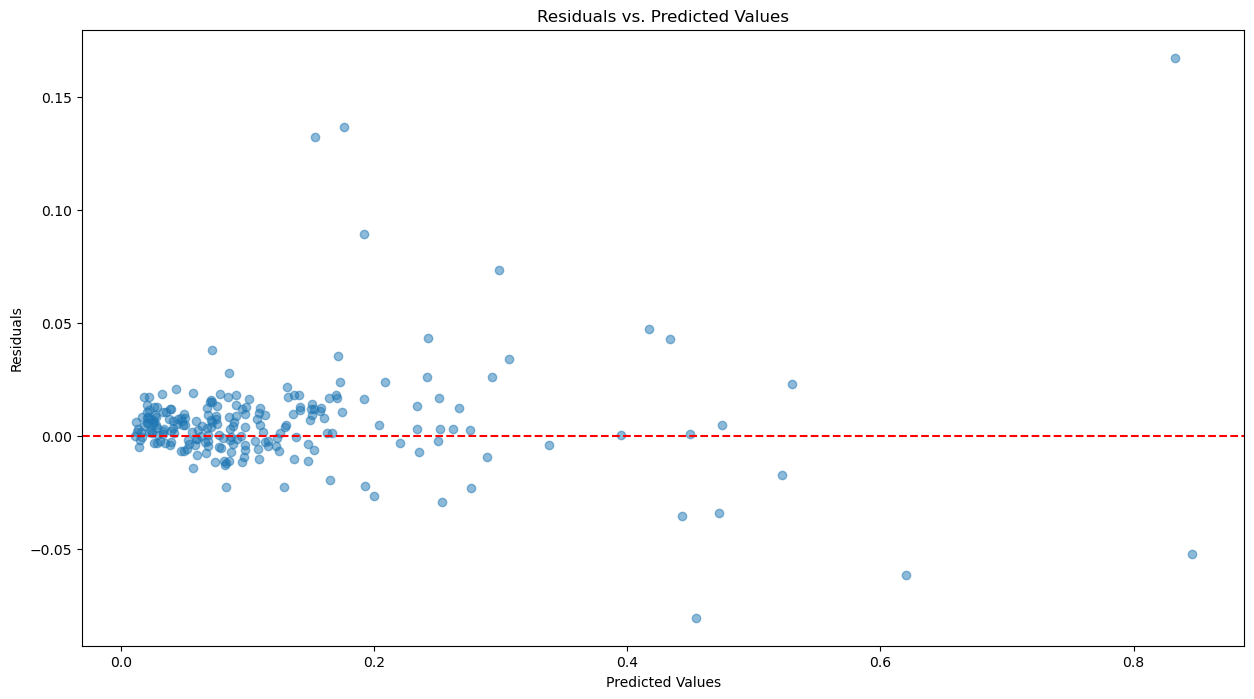

In [109]:
# Calculate residuals
residuals_xgb = y_test_1_xgb - y_pred_1_xgb

# Plot residuals
plt.figure(figsize=(15, 8))
plt.scatter(y_pred_1_xgb, residuals_xgb, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()


In [110]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse_xgb = mean_squared_error(y_test_1_xgb, y_pred_1_xgb)
print(f"Mean Squared Error (MSE): {mse_xgb}")

# Calculate RMSE
rmse_xgb = np.sqrt(mse_xgb)
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")


Mean Squared Error (MSE): 0.0005779831892462962
Root Mean Squared Error (RMSE): 0.024041280940213985


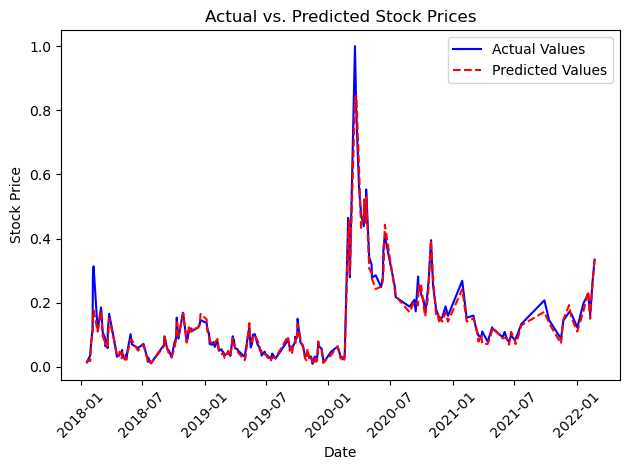

In [111]:
# Assuming you have a date column for the test set
test_dates = scaled1_df['Date'][split_point_rf:]

plt.plot(test_dates, y_test_1_xgb, label='Actual Values', color='blue')
plt.plot(test_dates, y_pred_1_xgb, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# XGBoost II

In [112]:
import xgboost as xgb

# Set random seed for reproducibility
np.random.seed(42)

# Sort the DataFrame by Date
scaled2_df = scaled2_df.sort_values(by='Date')

# Save the variable names for later use (excluding 'Date' and 'Indexvalue')
feature_names_2_xgb = scaled2_df.columns[scaled2_df.columns != 'Date']
feature_names_2_xgb = feature_names_2_xgb[feature_names_2_xgb != 'Indexvalue'].tolist()

# Drop the 'Date' column
scaled_data_2_xgb = scaled2_df.drop(columns=['Date']).values

# Define the split point
split_point_xgb = int(0.8 * len(scaled_data_2_xgb))

# Split the data into training and test sets
train_data_2_xgb = scaled_data_2_xgb[:split_point_xgb]
test_data_2_xgb = scaled_data_2_xgb[split_point_xgb:]

# Separate Features and Target
X_train_2_xgb = train_data_2_xgb[:, 1:]
y_train_2_xgb = train_data_2_xgb[:, 0]

X_test_2_xgb = test_data_2_xgb[:, 1:]
y_test_2_xgb = test_data_2_xgb[:, 0]


In [113]:
# Initialize the XGBoost Regressor
xgb_model_2 = xgb.XGBRegressor(
    n_estimators=200,  # Number of boosting rounds
    max_depth=6,       # Maximum depth of a tree
    learning_rate=0.1, # Step size shrinkage used in update to prevent overfitting
    objective='reg:squarederror', # Regression with squared loss
    random_state=42   # Seed for reproducibility
)

# Train the XGBoost model on the first dataset
xgb_model_2.fit(X_train_2_xgb, y_train_2_xgb)

# Predict on the test set for the first dataset
y_pred_2_xgb = xgb_model_2.predict(X_test_2_xgb)


In [114]:
feature_names_2_xgb

['10_y_bond_delta_1',
 'weighted_prob',
 'vstoxx_lag_1',
 'vstoxx_ma_7',
 'main_ref_rate',
 'moving_avg_sentiment',
 'euro_yield_lag_1',
 'Close_volatility',
 'dax_delta_1',
 'dax_lag_1',
 'Monday',
 'Thursday',
 'Tuesday',
 'Wednesday']

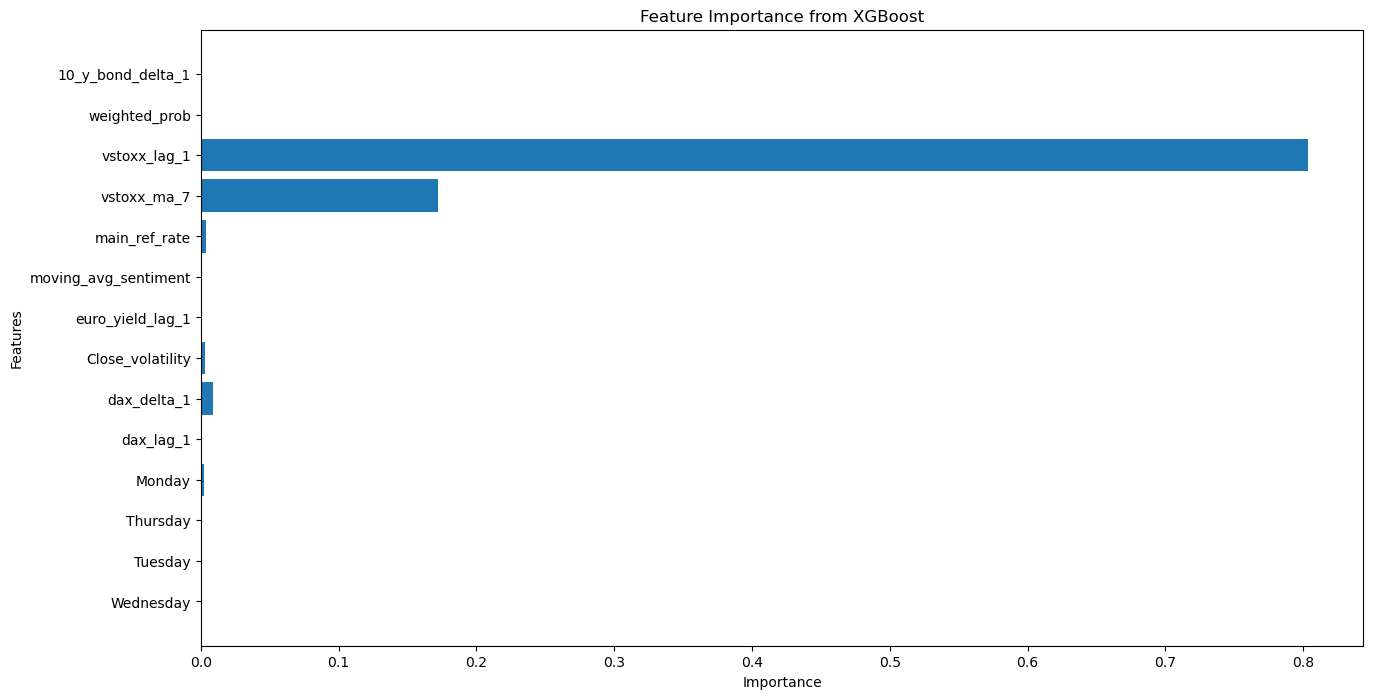

In [115]:
# Extract feature importances
feature_importance_xgb_2 = xgb_model_2.feature_importances_

# Plot feature importances
plt.figure(figsize=(15, 8))
plt.barh(feature_names_2_xgb, feature_importance_xgb_2, align='center')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.show()


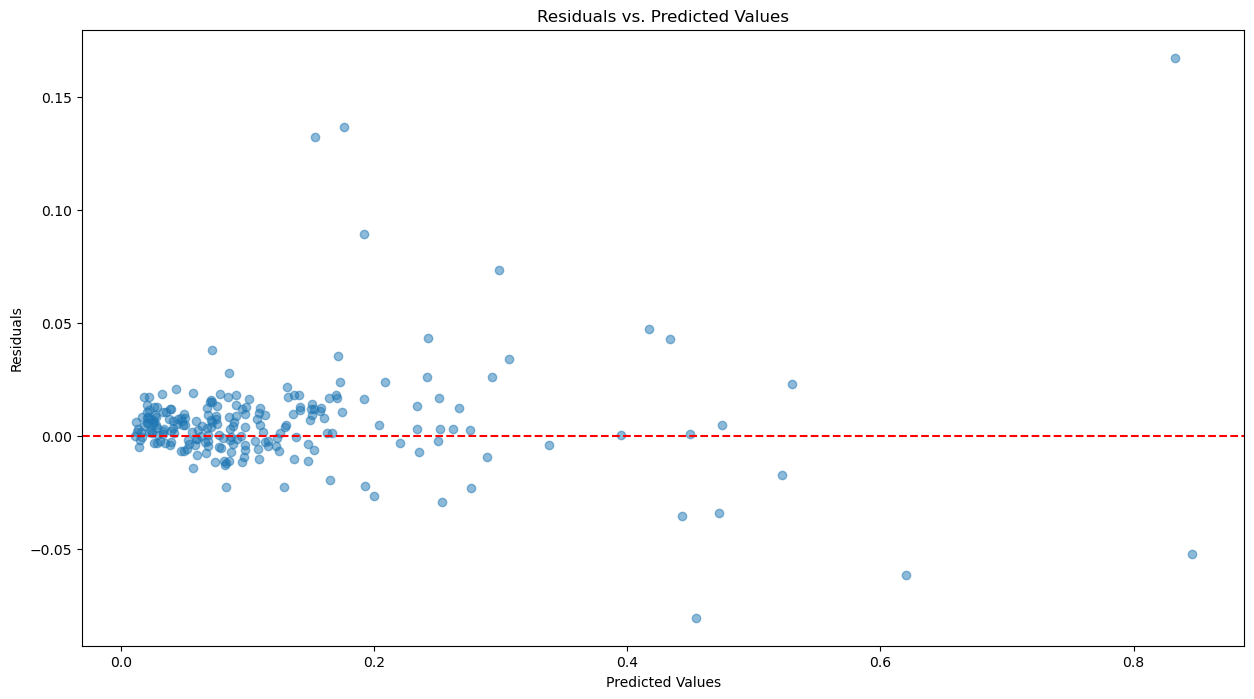

In [ ]:
# Calculate residuals
residuals_xgb = y_test_1_xgb - y_pred_1_xgb

# Plot residuals
plt.figure(figsize=(15, 8))
plt.scatter(y_pred_1_xgb, residuals_xgb, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()


In [116]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse_xgb_2 = mean_squared_error(y_test_2_xgb, y_pred_2_xgb)
print(f"Mean Squared Error (MSE): {mse_xgb_2}")

# Calculate RMSE
rmse_xgb_2 = np.sqrt(mse_xgb_2)
print(f"Root Mean Squared Error (RMSE): {rmse_xgb_2}")

Mean Squared Error (MSE): 0.0005766722106704837
Root Mean Squared Error (RMSE): 0.024014000305456893


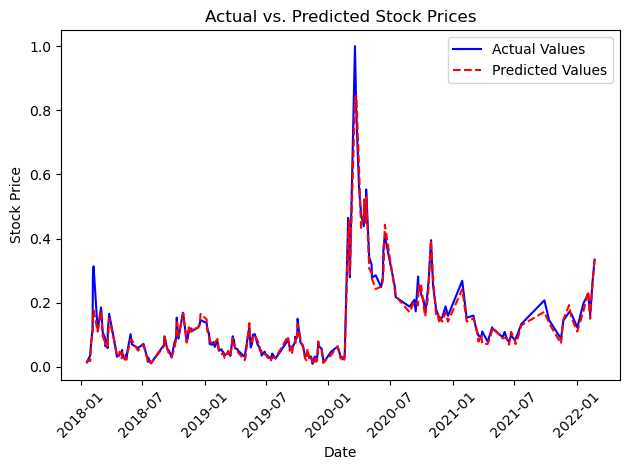

In [117]:
# Assuming you have a date column for the test set
test_dates = scaled1_df['Date'][split_point_rf:]

plt.plot(test_dates, y_test_1_xgb, label='Actual Values', color='blue')
plt.plot(test_dates, y_pred_1_xgb, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Statistical significance of the difference between models

This section assesses the impact of incorporating market sentiment indicators in our time series forecasting. We train two models: one using only historical data and another with added market sentiment. Using a sliding-window approach, their performance is compared over two test windows. The goal is to statistically determine if market sentiment enhances forecast accuracy.

In [493]:
scaled1_df

Indexvalue  10_y_bond_delta_1  vstoxx_lag_1  vstoxx_ma_7  main_ref_rate  \
0       0.035906           0.600374      0.038390     0.036785            1.0   
1       0.021974           0.522221      0.020462     0.019825            1.0   
2       0.029481           0.378967      0.019944     0.028009            1.0   
3       0.012090           0.330330      0.016304     0.015911            1.0   
4       0.036288           0.488350      0.029652     0.019063            1.0   
...          ...                ...           ...          ...            ...   
1086    0.197488           0.338188      0.126571     0.153245            0.0   
1087    0.228315           0.667383      0.177660     0.225911            0.0   
1088    0.162195           0.569213      0.139695     0.186492            0.0   
1089    0.265269           0.370380      0.207401     0.222885            0.0   
1090    0.334424           0.415338      0.290212     0.302132            0.0   

      euro_yield_lag_1  Close_volatility  dax_delta_1  dax_lag_1  Monday  \
0             0.640764          0.000000     0.493211   0.045468     0.0   
1             0.649444          0.000000     0.497805   0.050464     0.0   
2             0.681788          0.000000     0.512513   0.054656     1.0   
3             0.666233          0.000000     0.514934   0.060655     1.0   
4             0.669188          0.000000     0.516928   0.055605     1.0   
...                ...               ...          ...        ...     ...   
1086          0.094744          0.209706     0.236251   0.981068     0.0   
1087          0.144899          0.241233     0.271454   0.937498     0.0   
1088          0.165348          0.253277     0.518372   0.946594     0.0   
1089          0.162429          0.268154     0.396515   0.939709     0.0   
1090          0.163543          0.263549     0.455988   0.883383     0.0   

      Thursday  Tuesday  Wednesday       Date  
0          0.0      0.0        1.0 2005-01-26  
1          1.0      0.0        0.0 2005-02-03  
2          0.0      0.0        0.0 2005-02-28  
3          0.0      0.0        0.0 2005-03-07  
4          0.0      0.0        0.0 2005-03-14  
...        ...      ...        ...        ...  
1086       0.0      0.0        0.0 2022-01-21  
1087       0.0      0.0        0.0 2022-02-04  
1088       1.0      0.0        0.0 2022-02-10  
1089       1.0      0.0        0.0 2022-02-17  
1090       0.0      0.0        1.0 2022-02-23  

[1091 rows x 14 columns]

In [118]:
def expanding_window_split(X, test_ratio=0.2):
    """
    Generates indices for expanding window time series split.
    
    Parameters:
    - X: Data
    - test_ratio: Fraction of dataset to be used as test data.
    
    Returns:
    Generator of train indices and test indices.
    """
    num_samples = len(X)
    test_size = int(num_samples * test_ratio)
    
    if 2 * test_size > num_samples:
        raise ValueError("The dataset is not large enough for two test windows.")
    
    train_end = test_size  # Starting point for training set
    
    while train_end + test_size <= num_samples:
        yield (np.arange(0, train_end), np.arange(train_end, train_end + test_size))
        train_end += test_size

In [119]:
train_indices = []
test_indices = []

for train, test in expanding_window_split(X_1):
    train_indices.append((train[0], train[-1]))
    test_indices.append((test[0], test[-1]))

print("Train indices:", train_indices)
print("Test indices:", test_indices)


Train indices: [(0, 211), (0, 423), (0, 635), (0, 847)]
Test indices: [(212, 423), (424, 635), (636, 847), (848, 1059)]


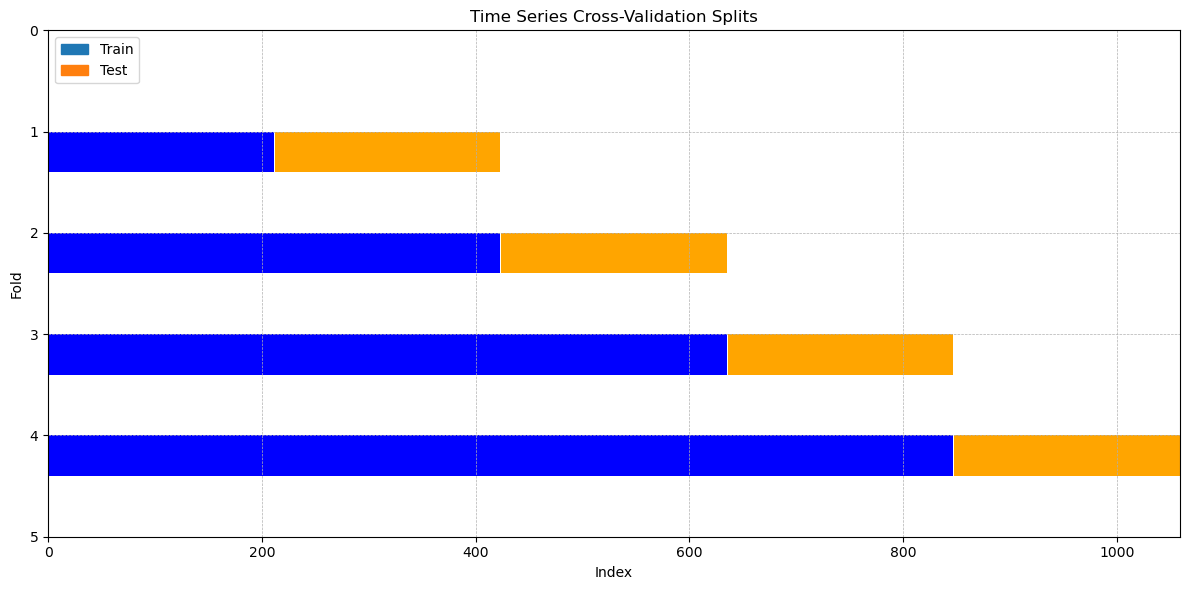

In [120]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_time_series_cv(train_indices, test_indices):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Add grid for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Set limits, labels, and title
    ax.set_xlim(0, test_indices[-1][-1])
    ax.set_ylim(0, len(train_indices) + 1)
    ax.set_ylabel('Fold')
    ax.set_xlabel('Index')
    ax.set_title('Time Series Cross-Validation Splits')
    
    # For each pair of train-test indices, plot the corresponding segments
    for idx, (train, test) in enumerate(zip(train_indices, test_indices)):
        ax.add_patch(patches.Rectangle((train[0], idx + 1), train[1]-train[0], 0.4, facecolor='blue'))
        ax.add_patch(patches.Rectangle((test[0], idx + 1), test[1]-test[0], 0.4, facecolor='orange'))

    # Add legend
    orange_patch = patches.Patch(color='#ff7f0e', label='Test')
    blue_patch = patches.Patch(color='#1f77b4', label='Train')
    ax.legend(handles=[blue_patch, orange_patch], loc="upper left")

    # invert y axis to have the first fold at the top
    ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

plot_time_series_cv(train_indices, test_indices)


In [121]:
# Initialize lists to store evaluation metrics and losses
test_mse_scores = []
test_rmse_scores = []
all_training_loss = []
all_validation_loss = []
sequence_length = 30  

for train_index, test_index in expanding_window_split(X_1):
    X_train_fold, X_test_fold = X_1[train_index], X_1[test_index]
    y_train_fold, y_test_fold = y_1[train_index], y_1[test_index]

    # Print current fold information
    print(f"Training on index range: {train_index[0]}-{train_index[-1]}")
    print(f"Testing on index range: {test_index[0]}-{test_index[-1]}")
    
    # Configure the model
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 12)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer=adam_optimizer, loss='mean_squared_error')
    
    # Train the model on the current fold data
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=64, validation_data=(X_test_fold, y_test_fold), verbose=1)

    # Storing training and validation loss
    all_training_loss.append(history.history['loss'])
    all_validation_loss.append(history.history['val_loss'])

    # Evaluate model on the test fold
    test_mse = model.evaluate(X_test_fold, y_test_fold, verbose=1)
    test_rmse = np.sqrt(test_mse)
    
    test_mse_scores.append(test_mse)
    test_rmse_scores.append(test_rmse)

Training on index range: 0-211
Testing on index range: 212-423
Epoch 1/50
4/4 [==============================] - 3s 202ms/step - loss: 0.0580 - val_loss: 0.0143
Epoch 2/50
4/4 [==============================] - 0s 34ms/step - loss: 0.0545 - val_loss: 0.0142
Epoch 3/50
4/4 [==============================] - 0s 32ms/step - loss: 0.0515 - val_loss: 0.0144
Epoch 4/50
4/4 [==============================] - 0s 33ms/step - loss: 0.0486 - val_loss: 0.0144
Epoch 5/50
4/4 [==============================] - 0s 34ms/step - loss: 0.0461 - val_loss: 0.0147
Epoch 6/50
4/4 [==============================] - 0s 33ms/step - loss: 0.0436 - val_loss: 0.0150
Epoch 7/50
4/4 [==============================] - 0s 34ms/step - loss: 0.0414 - val_loss: 0.0155
Epoch 8/50
4/4 [==============================] - 0s 34ms/step - loss: 0.0392 - val_loss: 0.0161
Epoch 9/50
4/4 [==============================] - 0s 42ms/step - loss: 0.0372 - val_loss: 0.0168
Epoch 10/50
4/4 [==============================] - 0s 40ms/step

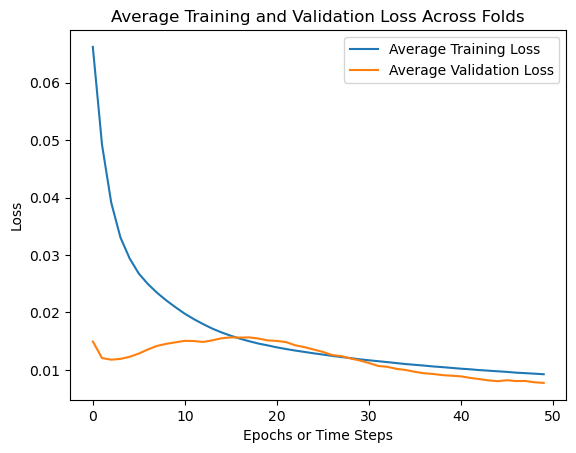

In [122]:
# Assuming each entry in all_training_loss and all_validation_loss is a list of loss values across time steps

# Calculate average training loss at each time step across splits
average_training_loss = [sum(x) / len(x) for x in zip(*all_training_loss)]

# Calculate average validation loss at each time step across splits
average_validation_loss = [sum(x) / len(x) for x in zip(*all_validation_loss)]

#plt.figure(figsize=(10, 6))

# Plot the average training and validation losses
plt.plot(average_training_loss, label='Average Training Loss')
plt.plot(average_validation_loss, label='Average Validation Loss')
plt.title('Average Training and Validation Loss Across Folds')
plt.xlabel('Epochs or Time Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Cross validation with sentiments added to the model


In [123]:
scaled2_df

Indexvalue  10_y_bond_delta_1  weighted_prob  vstoxx_lag_1  vstoxx_ma_7  \
0       0.035906           0.600374       0.881511      0.038390     0.036785   
1       0.021974           0.522221       0.863662      0.020462     0.019825   
2       0.029481           0.378967       0.551835      0.019944     0.028009   
3       0.012090           0.330330       0.226526      0.016304     0.015911   
4       0.036288           0.488350       1.000000      0.029652     0.019063   
...          ...                ...            ...           ...          ...   
1086    0.197488           0.338188       0.938415      0.126571     0.153245   
1087    0.228315           0.667383       0.528345      0.177660     0.225911   
1088    0.162195           0.569213       0.458849      0.139695     0.186492   
1089    0.265269           0.370380       0.613944      0.207401     0.222885   
1090    0.334424           0.415338       0.766967      0.290212     0.302132   

      main_ref_rate  moving_avg_sentiment  euro_yield_lag_1  Close_volatility  \
0               1.0              0.824089          0.640764          0.000000   
1               1.0              0.816841          0.649444          0.000000   
2               1.0              0.774259          0.681788          0.000000   
3               1.0              0.687878          0.666233          0.000000   
4               1.0              0.748571          0.669188          0.000000   
...             ...                   ...               ...               ...   
1086            0.0              0.603029          0.094744          0.209706   
1087            0.0              0.586222          0.144899          0.241233   
1088            0.0              0.574059          0.165348          0.253277   
1089            0.0              0.622397          0.162429          0.268154   
1090            0.0              0.614280          0.163543          0.263549   

      dax_delta_1  dax_lag_1  Monday  Thursday  Tuesday  Wednesday       Date  
0        0.493211   0.045468     0.0       0.0      0.0        1.0 2005-01-26  
1        0.497805   0.050464     0.0       1.0      0.0        0.0 2005-02-03  
2        0.512513   0.054656     1.0       0.0      0.0        0.0 2005-02-28  
3        0.514934   0.060655     1.0       0.0      0.0        0.0 2005-03-07  
4        0.516928   0.055605     1.0       0.0      0.0        0.0 2005-03-14  
...           ...        ...     ...       ...      ...        ...        ...  
1086     0.236251   0.981068     0.0       0.0      0.0        0.0 2022-01-21  
1087     0.271454   0.937498     0.0       0.0      0.0        0.0 2022-02-04  
1088     0.518372   0.946594     0.0       1.0      0.0        0.0 2022-02-10  
1089     0.396515   0.939709     0.0       1.0      0.0        0.0 2022-02-17  
1090     0.455988   0.883383     0.0       0.0      0.0        1.0 2022-02-23  

[1091 rows x 16 columns]

In [124]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


# Step 1: Data Preparation
# Extract features and target. Assuming target column is named 'target'. Adjust if it's different.
X_2 = scaled2_df.drop(columns=['Date', 'Indexvalue']).values
y_2 = scaled2_df['Indexvalue'].values

num_features = X_2.shape[1]

# Convert data into sequences for LSTM
def transform_to_sequences(data, target, sequence_length):
    seq_data = []
    seq_target = []

    for i in range(len(data) - sequence_length):
        seq_data.append(data[i:i + sequence_length])
        seq_target.append(target[i + sequence_length])

    return np.array(seq_data), np.array(seq_target)

X_2, y_2 = transform_to_sequences(X_2, y_2, sequence_length)


# Step 3: Model Training and Evaluation
test_mse_scores_2 = []
test_rmse_scores_2 = []
all_training_loss_2 = []
all_validation_loss_2 = []

for train_index, test_index in expanding_window_split(X_2):
    X_train_fold, X_test_fold = X_2[train_index], X_2[test_index]
    y_train_fold, y_test_fold = y_2[train_index], y_2[test_index]

    # Print current fold information
    print(f"Training on index range: {train_index[0]}-{train_index[-1]}")
    print(f"Testing on index range: {test_index[0]}-{test_index[-1]}")
    
    # Configure the model
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer=adam_optimizer, loss='mean_squared_error')
    
    # Train the model on the current fold data
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=64, validation_data=(X_test_fold, y_test_fold), verbose=1)

    # Storing training and validation loss
    all_training_loss_2.append(history.history['loss'])
    all_validation_loss_2.append(history.history['val_loss'])

    # Evaluate model on the test fold
    test_mse = model.evaluate(X_test_fold, y_test_fold, verbose=1)
    test_rmse = np.sqrt(test_mse)
    
    test_mse_scores_2.append(test_mse)
    test_rmse_scores_2.append(test_rmse)


Training on index range: 0-211
Testing on index range: 212-423
Epoch 1/50
4/4 [==============================] - 3s 229ms/step - loss: 0.0723 - val_loss: 0.0380
Epoch 2/50
4/4 [==============================] - 0s 38ms/step - loss: 0.0628 - val_loss: 0.0289
Epoch 3/50
4/4 [==============================] - 0s 38ms/step - loss: 0.0562 - val_loss: 0.0223
Epoch 4/50
4/4 [==============================] - 0s 39ms/step - loss: 0.0506 - val_loss: 0.0180
Epoch 5/50
4/4 [==============================] - 0s 37ms/step - loss: 0.0469 - val_loss: 0.0151
Epoch 6/50
4/4 [==============================] - 0s 38ms/step - loss: 0.0436 - val_loss: 0.0135
Epoch 7/50
4/4 [==============================] - 0s 39ms/step - loss: 0.0409 - val_loss: 0.0125
Epoch 8/50
4/4 [==============================] - 0s 38ms/step - loss: 0.0380 - val_loss: 0.0119
Epoch 9/50
4/4 [==============================] - 0s 38ms/step - loss: 0.0354 - val_loss: 0.0116
Epoch 10/50
4/4 [==============================] - 0s 36ms/step

In [125]:
# Metrics for Test MSE and Test RMSE
mean_test_mse_2 = np.mean(test_mse_scores_2)
std_test_mse_2 = np.std(test_mse_scores_2)
mean_test_rmse_2 = np.mean(test_rmse_scores_2)
std_test_rmse_2 = np.std(test_rmse_scores_2)

print(f"Mean Test MSE: {mean_test_mse_2:.5f}")
print(f"Standard Deviation of Test MSE: {std_test_mse_2:.5f}")
print(f"Mean Test RMSE: {mean_test_rmse_2:.5f}")
print(f"Standard Deviation of Test RMSE: {std_test_rmse_2:.5f}")


Mean Test MSE: 0.00807
Standard Deviation of Test MSE: 0.00502
Mean Test RMSE: 0.08467
Standard Deviation of Test RMSE: 0.03009


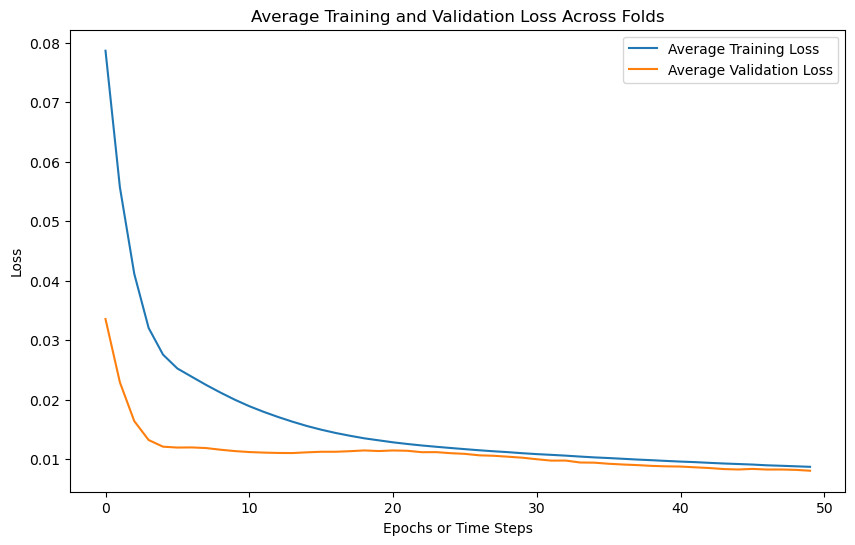

In [126]:
# Calculate average training loss at each time step across splits
average_training_loss_2 = [sum(x) / len(x) for x in zip(*all_training_loss_2)]

# Calculate average validation loss at each time step across splits
average_validation_loss_2 = [sum(x) / len(x) for x in zip(*all_validation_loss_2)]

# Plot the average training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(average_training_loss_2, label='Average Training Loss')
plt.plot(average_validation_loss_2, label='Average Validation Loss')
plt.title('Average Training and Validation Loss Across Folds')
plt.xlabel('Epochs or Time Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()


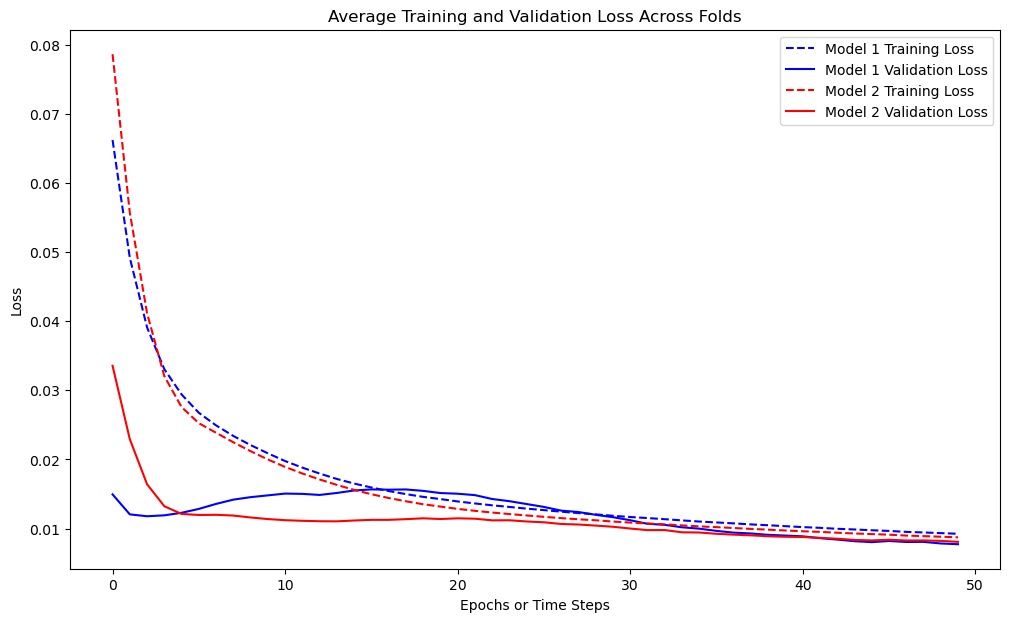

In [129]:
import matplotlib.pyplot as plt

# Assuming your first model's data is without `_2` suffix and second's with `_2`.

# Combined Average Training & Validation Loss Curves
plt.figure(figsize=(12, 7))
plt.plot(average_training_loss, label='Model 1 Training Loss', color='blue', linestyle='--')
plt.plot(average_validation_loss, label='Model 1 Validation Loss', color='blue')
plt.plot(average_training_loss_2, label='Model 2 Training Loss', color='red', linestyle='--')
plt.plot(average_validation_loss_2, label='Model 2 Validation Loss', color='red')
plt.title('Average Training and Validation Loss Across Folds')
plt.xlabel('Epochs or Time Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()



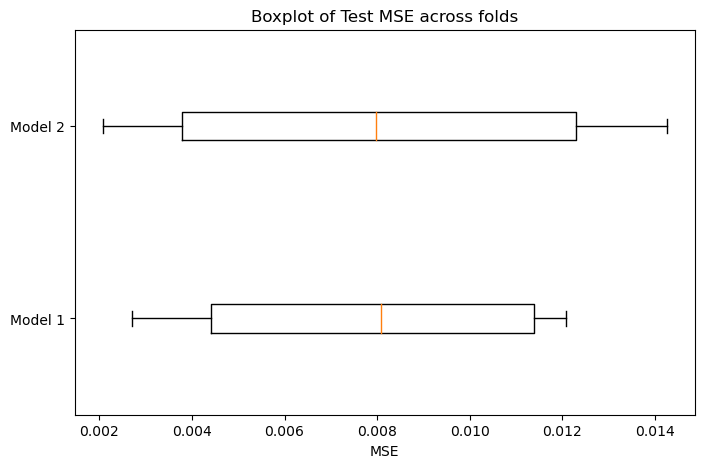

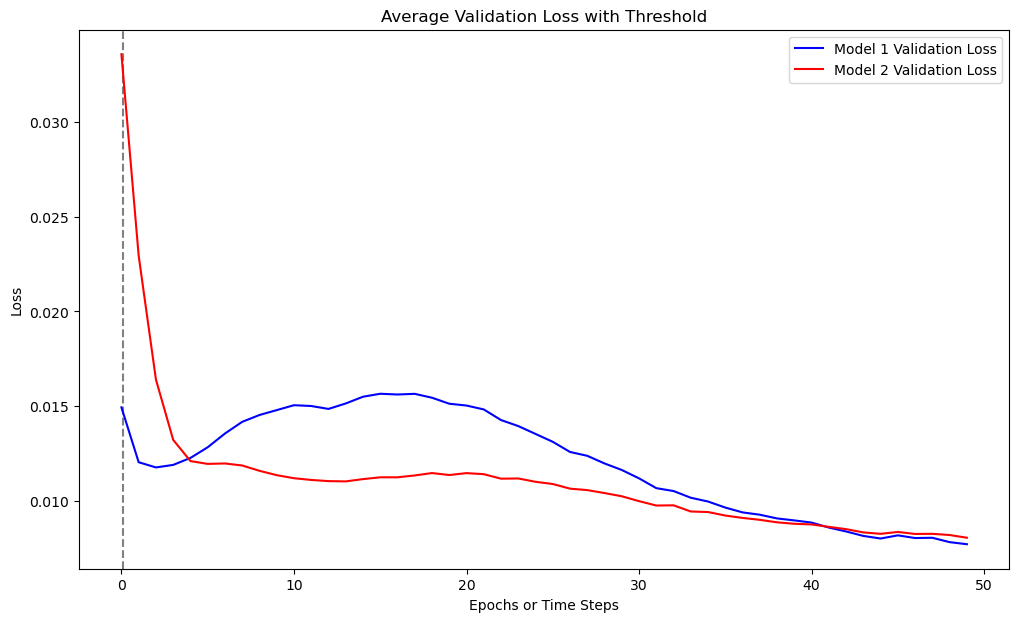

In [130]:
# Box plot of Test RMSE for both models
plt.figure(figsize=(8, 5))
plt.boxplot([test_mse_scores, test_mse_scores_2], vert=False, labels=['Model 1', 'Model 2'])
plt.title('Boxplot of Test MSE across folds')
plt.xlabel('MSE')
plt.show()

# Assuming a threshold value, plot for reference
threshold = 0.1  # Replace with your threshold

plt.figure(figsize=(12, 7))
plt.axvline(x=threshold, color='grey', linestyle='--')
plt.plot(average_validation_loss, label='Model 1 Validation Loss', color='blue')
plt.plot(average_validation_loss_2, label='Model 2 Validation Loss', color='red')
plt.title('Average Validation Loss with Threshold')
plt.xlabel('Epochs or Time Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()


AttributeError: 'Axes' object has no attribute 'set_zlabel'

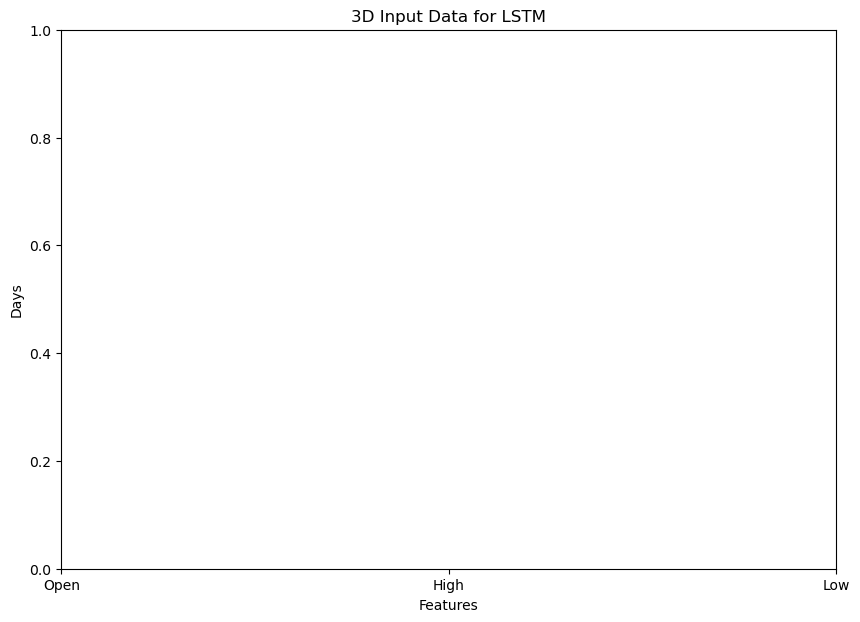

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data: 10 days of stock prices with 3 features (Open, High, Low)
data = np.array([
    [1, 2, 1.5],
    [1.5, 2.5, 1.4],
    [2, 3, 2.5],
    [2.5, 3.5, 2.4],
    [3, 4, 3.5],
    [3.5, 4.5, 3.4],
    [4, 5, 4.5],
    [4.5, 5.5, 4.4],
    [5, 6, 5.5],
    [5.5, 6.5, 5.4]
])

sequence_length = 3

# Extract sequences
sequences = []
for i in range(len(data) - sequence_length):
    sequences.append(data[i:i+sequence_length])

sequences = np.array(sequences)

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('3D Input Data for LSTM')
ax.set_xticks(np.arange(data.shape[1]))
ax.set_xticklabels(['Open', 'High', 'Low'])
ax.set_xlabel('Features')
ax.set_ylabel('Days')
ax.set_zlabel('Value')

# Plot each sequence
for i, sequence in enumerate(sequences):
    for j, day in enumerate(sequence):
        ax.scatter(np.arange(data.shape[1]), [i+j]*data.shape[1], day, marker='o')

ax.view_init(30, 225)  # Adjust the viewing angle for better visualization
plt.show()


# Permutation importance

In [132]:
from sklearn.metrics import mean_squared_error

# 1. Compute the Baseline Performance
baseline_predictions = model_2_LSTM.predict(X_test_2)
baseline_mse = mean_squared_error(y_test_2, baseline_predictions)

 1/10 [==>...........................] - ETA: 0s

10/10 [==============================] - 0s 10ms/step


In [133]:
# list of feature names to be permuted
feature_names = ["moving_average_sentiment", "weighted_prob"]

# extract the index of the feature names
feature_name_to_idx = {name: idx for idx, name in enumerate(feature_names)}

# permutation importance function
def compute_permutation_importance(model, X_test, y_test, feature_names, n_repeats=30):
    importances = {feature: 0 for feature in feature_names}
    
    for _ in range(n_repeats):
        for feature in feature_names:
            feature_idx = feature_name_to_idx[feature]
            X_test_permuted = X_test.copy()
            np.random.shuffle(X_test_permuted[:, feature_idx])
            permuted_predictions = model.predict(X_test_permuted)
            permuted_mse = mean_squared_error(y_test, permuted_predictions)
            importances[feature] += (permuted_mse - baseline_mse) / n_repeats  # accumulate and average
    
    return importances

In [134]:
# Compute averaged permutation importance for the desired features
features_to_permute = ["moving_average_sentiment", "weighted_prob"]
importances = compute_permutation_importance(model_2_LSTM, X_test_2, y_test_2, features_to_permute)

# set the number of repeats
n_repeats=30
# Print the averaged results
for feature, importance in importances.items():
    print(f"Permutation Importance of {feature} (averaged over {n_repeats} repeats):", importance)

10/10 [==============================] - 0s 5ms/step
Permutation Importance of moving_average_sentiment (averaged over 30 repeats): 2.3316907080110692e-05
Permutation Importance of weighted_prob (averaged over 30 repeats): 5.297904963712012e-06


# Permuted Transformers

In [135]:
# Print the results
print(f"Mean Squared Error (MSE): {mse_scaled_transformers_2}")
print(f"Root Mean Squared Error (RMSE): {rmse_scaled_transformers_2}")


Mean Squared Error (MSE): 0.08652096595168964
Root Mean Squared Error (RMSE): 0.2941444644246933


In [136]:
# Compute averaged permutation importance for the desired features
features_to_permute = ["moving_average_sentiment", "weighted_prob"]
importances = compute_permutation_importance(model_2_transformers, X_2_test_seq, y_2_test_seq, features_to_permute)

# set the number of repeats
n_repeats=30
# Print the averaged results
for feature, importance in importances.items():
    print(f"Permutation Importance of {feature} (averaged over {n_repeats} repeats):", importance)

10/10 [==============================] - 0s 3ms/step
Permutation Importance of moving_average_sentiment (averaged over 30 repeats): 0.04772552314686902
Permutation Importance of weighted_prob (averaged over 30 repeats): 0.04782865917870012


# Randomness in LSTM